# Exploring My Spotify Preferences

## Introduction

Spotify is my audio streaming platform of choice, and I have been using it for many years now. At the end of each year, Spotify releases a program that allows each user to see a recap of their listening preferences throughout that year, but there is no way to explore during any other period.

Spotify allows you to download a personal report containing data that has been recorded over the last 365 days. Here, what I am mainly interested in is the "Streaming History" files which contain every song/podcast that I have ever opened/listened to along with the date/time of the stream and the time played in milliseconds. Unfortunately, Spotify does not include the genre of the song, so no major analysis can be performed without a heavy amount of manual data entry. However, there is enough information to make certain interesting inferences.

## Dataset

The data comes in multiple JSON files depending on user listening activity as each file contains 10,000 entries max. Each entry includes the following pieces of information:

* endTime: The date and time that the stream ended (as a string)
* artistName: The name of the artist
* trackName: The name of the track
* msPlayed: The amount of time the track was streamed (in ms)

Example entry:

![Example entry from the JSON file](ex_entry.png)

For easier analysis, the endTime column was converted into datetime format while the msPlayed column was converted into seconds.

## Goals

* Which songs/artists do I listen to the most? the least?
* Which songs/artists did I enjoy the most each month?
* Which songs/artists do I most often skip? (seconds played under 10 seconds)
    * I can then delete these songs from my playlists

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import math
import statistics

## Preprocessing

Some steps will be taken to clean up the data before analysis begins. First, the data needs to be compiled into a single file to simplify the process - Spotify's data is split into several files, the number of which depends on the amount of total streams in the year.

The resulting data frame needs a few tweaks as well:
* The msPlayed column will be converted to sPlayed as seconds are easier to understand than milliseconds
* The endTime column will be converted to date time
* The streamtime (sPlayed column) will be limited to 6 minutes as some songs are erroneously measured beyond that.
    * Likely this is a situation where the song was restarted mid-stream
* Any songs with a streamtime of 0 will be deleted (These are errors)
* Any songs with a streamtime of less than 0.5 seconds will be deleted (from my listening habits, if the streamtime is less than a second, it is because I am intentionally skipping several songs in a row, but I'm arbitrarily cutting it off at 0.5 seconds to still capture some of these skips)

In [2]:
# Preprocessing
# Combine the streaming history files into one csv file

import json

files = ['JStreamingHistory_2021_1.json', 'JStreamingHistory_2021_2.json', 'JStreamingHistory_2021_3.json']
#files = ['AStreamingHistory0.json', 'AStreamingHistory1.json']
outputname = 'spotify_analytics_df.csv' 

output_df = pd.DataFrame()

for onefile in files:
    with open(onefile, encoding='utf8') as s_file:
        data = json.load(s_file)
    
    output_df = pd.concat([output_df, pd.DataFrame(data)], axis=0)
    
output_df.to_csv(outputname, index=False)

print('Before processing')
output_df.head(10)

Before processing


,endTime,artistName,trackName,msPlayed
0,2020-12-04 00:53,jeebanoff,Then We,4449
1,2020-12-04 18:36,NCT 127,Chain - Korean Version,6906
2,2020-12-04 18:39,NCT U,90's Love,212384
3,2020-12-04 18:43,SEVENTEEN,AH! LOVE,194626
4,2020-12-04 18:45,Loote,tomorrow tonight,129696
...,...,...,...,...
7050,2021-12-04 23:45,CRAVITY,Flame,194333
7051,2021-12-04 23:48,YUNHWAY,Colors,206226
7052,2021-12-04 23:52,OH MY GIRL,Dun Dun Dance,220560
7053,2021-12-04 23:55,HA SUNG WOON,Sneakers,194520


In [3]:
spotify_df = pd.read_csv('spotify_analytics_df.csv')

#Convert the msPlayed column to seconds (sPlayed)
spotify_df['msPlayed'] = spotify_df['msPlayed']/1000
spotify_df.rename(columns = {'msPlayed':'sPlayed'}, inplace = True)

#Convert the endTime column to datetime
spotify_df.endTime = pd.to_datetime(spotify_df.endTime)

#Cap the streamtimes at 7 minutes (420 seconds), as some songs are registering an abnormal song length 
#(exceeding 10 minutes in some cases)
spotify_df = spotify_df[ spotify_df['sPlayed'] <= 420 ]

#Delete any streamtimes that are 0 (most likely play errors)
spotify_df = spotify_df[ spotify_df['sPlayed'] > 0]

#Define a copy of the data frame for analysis
spotify_df2 = spotify_df.copy()

print('After processing')
spotify_df2.head(10)

After processing


,endTime,artistName,trackName,sPlayed
0,2020-12-04 00:53:00,jeebanoff,Then We,4.449
1,2020-12-04 18:36:00,NCT 127,Chain - Korean Version,6.906
2,2020-12-04 18:39:00,NCT U,90's Love,212.384
3,2020-12-04 18:43:00,SEVENTEEN,AH! LOVE,194.626
4,2020-12-04 18:45:00,Loote,tomorrow tonight,129.696
...,...,...,...,...
27050,2021-12-04 23:45:00,CRAVITY,Flame,194.333
27051,2021-12-04 23:48:00,YUNHWAY,Colors,206.226
27052,2021-12-04 23:52:00,OH MY GIRL,Dun Dun Dance,220.560
27053,2021-12-04 23:55:00,HA SUNG WOON,Sneakers,194.520


In [4]:
# Check for any N/A values
spotify_df2.isnull().sum()

endTime       0
artistName    0
trackName     0
sPlayed       0
dtype: int64

In [5]:
spotify_df2.describe()

,sPlayed
count,26822.000000
mean,161.545325
std,78.830042
min,0.001000
25%,159.749000
50%,193.631000
75%,206.616000
max,418.930000


In [6]:
spotify_df2.nunique()

endTime       23242
artistName      548
trackName      1809
sPlayed        7312
dtype: int64

## Initial analysis of the data set

After preprocessing, there are no N/A values in the dataset. There are 26754 rows meaning that there are 26754 total streams. There are 548 unique artists and 1809 unique tracks in the dataset.

The shortest stream length is 0.501 seconds while the longest is 359.097 seconds. The mean stream length is 164.5 seconds (which is about 2 minutes and 45 seconds) and the standard deviation is 75.23 seconds.

This means that, assuming a normal distribution, most streams fall within the range of 1 minute and 30 seconds (89.27 seconds) and 4 minutes (239.73 seconds). 

## Combining the trackName and artistName columns

During my analysis, I ran into errors where songs weren't being counted properly and found that this occurs when multiple songs share the same title. While this is rare, it comes up often enough to be problematic. For example, below I extract a data frame consisting of songs called 'Home' where 65 streams belong to SEVENTEEN while 59 belong to Gaho. If I were to try to count the number of streams for a song, I would also need to account for the artist to avoid counting songs twice (or completely missing streams by another artist).

By combining the trackName and artistName columns, I solve this issue completely, ensuring that every song by every artist is accounted for in the analysis

In [7]:
# Show streams for 'Home'
home_df = spotify_df2[spotify_df2['trackName'] == 'Home']

n_home = len(home_df)
n_home_svt = len(home_df[home_df['artistName'] == 'SEVENTEEN'])
n_home_gaho = len(home_df[home_df['artistName'] == 'Gaho'])

print('The number of streams of songs called \'Home\':', n_home, '\n')
print('The number of streams of \'Home\' by SEVENTEEN:', n_home_svt)
print('The number of streams of \'Home\' by Gaho:', n_home_gaho)


home_df.head(10)

The number of streams of songs called 'Home': 124 

The number of streams of 'Home' by SEVENTEEN: 65
The number of streams of 'Home' by Gaho: 59


,endTime,artistName,trackName,sPlayed
662,2020-12-29 00:57:00,SEVENTEEN,Home,1.385
1647,2021-01-16 20:19:00,SEVENTEEN,Home,203.731
1943,2021-01-23 02:36:00,SEVENTEEN,Home,1.271
1947,2021-01-23 02:37:00,SEVENTEEN,Home,94.792
3370,2021-02-28 22:01:00,Gaho,Home,0.900
...,...,...,...,...
24083,2021-11-13 21:57:00,SEVENTEEN,Home,203.731
24179,2021-11-15 00:19:00,Gaho,Home,1.467
26588,2021-12-02 09:24:00,SEVENTEEN,Home,203.731
26640,2021-12-02 12:16:00,Gaho,Home,205.566


In [8]:
# Combine the artistName and trackName columns into a 'both' column
spotify_df2['both'] = spotify_df2['trackName'] + '__' + spotify_df2['artistName']

spotify_df2.head(10)

,endTime,artistName,trackName,sPlayed,both
0,2020-12-04 00:53:00,jeebanoff,Then We,4.449,Then We__jeebanoff
1,2020-12-04 18:36:00,NCT 127,Chain - Korean Version,6.906,Chain - Korean Version__NCT 127
2,2020-12-04 18:39:00,NCT U,90's Love,212.384,90's Love__NCT U
3,2020-12-04 18:43:00,SEVENTEEN,AH! LOVE,194.626,AH! LOVE__SEVENTEEN
4,2020-12-04 18:45:00,Loote,tomorrow tonight,129.696,tomorrow tonight__Loote
...,...,...,...,...,...
27050,2021-12-04 23:45:00,CRAVITY,Flame,194.333,Flame__CRAVITY
27051,2021-12-04 23:48:00,YUNHWAY,Colors,206.226,Colors__YUNHWAY
27052,2021-12-04 23:52:00,OH MY GIRL,Dun Dun Dance,220.560,Dun Dun Dance__OH MY GIRL
27053,2021-12-04 23:55:00,HA SUNG WOON,Sneakers,194.520,Sneakers__HA SUNG WOON


In [9]:
spotify_df2.sort_values('sPlayed').head(10)

,endTime,artistName,trackName,sPlayed,both
19789,2021-09-11 21:13:00,PENTAGON,DO or NOT,0.001,DO or NOT__PENTAGON
10920,2021-06-05 05:29:00,BDC,CHEMICAL,0.020,CHEMICAL__BDC
24164,2021-11-14 05:44:00,ATEEZ,Fireworks (I'm The One),0.021,Fireworks (I'm The One)__ATEEZ
1544,2021-01-15 21:57:00,Carly Rae Jepsen,Cut To The Feeling,0.021,Cut To The Feeling__Carly Rae Jepsen
2548,2021-02-05 20:22:00,CRAVITY,Mammoth,0.021,Mammoth__CRAVITY
...,...,...,...,...,...
4560,2021-03-23 20:21:00,Golden Child,What Happened?,406.853,What Happened?__Golden Child
21868,2021-10-18 21:17:00,Youngjae,Vibin,409.532,Vibin__Youngjae
22685,2021-10-26 02:07:00,JAY B,FAME (feat. JUNNY) - Prod. GroovyRoom,414.858,FAME (feat. JUNNY) - Prod. GroovyRoom__JAY B
26376,2021-12-01 02:35:00,SEVENTEEN,Pretty U,416.666,Pretty U__SEVENTEEN


## Calculating song length

There are two notable flaw in Spotify's saved user data:
* The length of each song is not included
* There is no indication whether or not a song was completely streamed 

Without this information, it is difficult to extract a lot of useful information including: 
* The number of times each song was streamed to completion
* The average percent of each song that is streamed
* The average song length

There are also some interesting consequences that I have determined through experimentation

* Some streams are abnormally long
    * Many songs tend to be around 3 minutes long (240s). However, some songs had stream times of over 6 minutes (360s). While songs longer than 3-4 minutes are not uncommon, they certainly are uncommon in my listening history. As the msPlayed column contains the amount of a song that is streamed, these rows likely represented songs that were rewinded midstream, enabling the timer to go past the actual song length
* Some songs only had very short streams
    * There were some songs that only had streams shorter than 60s, but my playlists contain very few songs even under 2 minutes. As the msPlayed column contains the amount of a song that is streamed, these rows represented songs that were skipped before completion.
* Some songs had multiple streams of the same length
    * As the stream time is recorded in ms, it is unlikely to have multiple streams with the same length, but this occurred frequently. I determined that instances for one song with the same streamtime above some threshold were most likely the song's length, and that these instances represented completed streams.

To extract the length of each song, I performed the following steps.

* For all songs, any stream below 1 second is set aside
    * This is because some songs were autoskipped at the exact time, making some songs register multiple modes, one being the song length, the other being the skip time
* For songs where a mode still exists (at least two streams of the same length longer than 1 second), any stream longer than the mode will be set to the mode
    * In this case, the mode should be the song length as it is unlikely to have stream lengths match otherwise
* For songs where a mode does not exist, the longest stream will be set as the temporary song length
    * Without accessing a database containing every song's runtime, the longest stream time is the best guess without extra information
    
The mean song length is then calculated from the song lengths obtained above as well as the standard deviation. The value of interest is 1 standard deviation below the mean song length.
* For all songs
    * \[NO MODE\] If the calculated song length falls below .5 standard deviation below the average song length:
        * The song length is set to the mean
        * In theory, these songs should all be only partially streamed, so the mean is the best estimate for song length
    * \[MODE EXISTS\] If the calculated song length falls below 1 standard deviation below the average song length:
        * The song length is set to the mean
        * The .agg(pd.Series.mode) will output a mode if there is only 1 stream but this is an unreliable indicator of a song's length (since the stream could have just been 1 second, for example). This rule will at estimate the actual song length for such instances.
    * If the calculated song length is above 1 standard deviation below the average song length:
        * Nothing changes
        * In theory, these songs should all be only partially streamed, but enough of the song was streamed for this value to estimate the song length


In [10]:
# Create a dataframe consisting of songs from the original spotify_df2 with number of streams
template = pd.DataFrame(spotify_df2[['both', 'trackName', 'artistName']]).drop_duplicates('both')
template['index_both'] = template['both']
template = template.set_index('index_both')

# Add a column to record number of streams
template['n_stream'] = spotify_df2['both'].value_counts().rename('n_stream')

# Make a copy that will be used for this analysis
temp_song = template.copy()
temp_spot = spotify_df2[spotify_df2['both'].isin(temp_song['both'])]


# Find the mode for each song - if the mode exists, set 'mode_exists' to 1
# IF 'song_length' has multiple entries, then there was no conclusive mode - set to longest stream
# IF mode does not exist, set mode_exists to 0 and song_length to the longest stream
temp_spot_1s = temp_spot[temp_spot['sPlayed'] > 120]
temp_song['song_length'] = temp_spot_1s.groupby('both')['sPlayed'].agg(pd.Series.mode)
nomode_df = temp_song.copy()
temp_song['mode_exists'] = 1

for (i,value) in zip(temp_song.index, temp_song['song_length']):
    if type(value) == np.ndarray:
        temp_song.loc[i, 'song_length'] = max(value)
        temp_song.loc[i, 'mode_exists'] = 0

# Assign the mean song length to any song where the song_length was set to NAN
temp_song.loc[temp_song['song_length'].isna(), 'mode_exists'] = 0
for ind in temp_song[temp_song['song_length'].isna() == True].index:
    longest_stream = temp_spot.loc[temp_spot['both'] == ind, 'sPlayed'].max()
    temp_song.loc[temp_song['both'] == ind, 'song_length'] = longest_stream

# Assign the mean song length to any song with a song length less than 1 std dev below the mean 
stream_mean = temp_song['song_length'].mean()
stream_std = temp_song['song_length'].std()
cutoff_nomode = stream_mean - (stream_std * .5)
cutoff_mode = stream_mean - (stream_std)


condition_nomode = ( (temp_song['song_length'] < cutoff_nomode) & (temp_song['mode_exists'] == 0))
condition_mode = ( (temp_song['song_length'] < cutoff_mode) & (temp_song['mode_exists'] == 0))
temp_song.loc[condition_nomode, 'song_length'] = stream_mean
temp_song.loc[condition_mode, 'song_length'] = stream_mean

stream_mean2 = temp_song['song_length'].mean()
stream_std2 = temp_song['song_length'].std()


print('Initial Mean stream length: {:.2f}s ({:.0f}m {:.2f}s)'.format(stream_mean, stream_mean//60, stream_mean%60))
print('Initial STD Dev of stream length: {:.2f}s ({:.0f}m {:.2f}s)'.format(stream_std, stream_std//60, stream_std%60))
print('')
print('Cutoff for songs without a mode - songs where the longest stream is less than this are assigned the mean length:')
print('{:.2f}s ({:.0f}m {:.2f}s)'.format(cutoff_nomode, cutoff_nomode//60, cutoff_nomode%60))
print('Cutoff for songs with a mode - songs where the longest stream is less than this are assigned the mean length:')
print('{:.2f}s ({:.0f}m {:.2f}s)'.format(cutoff_mode, cutoff_mode//60, cutoff_mode%60))
print('')

print('Updated Mean stream length: {:.2f}s ({:.0f}m {:.2f}s)'.format(stream_mean2, stream_mean2//60, stream_mean2%60))
print('Updated STD Dev of stream length: {:.2f}s ({:.0f}m {:.2f}s)'.format(stream_std2, stream_std2//60, stream_std2%60))


# Reassign the final data frames as the templates
template_track = temp_song.copy()
template_spot = temp_spot.copy()

Initial Mean stream length: 165.92s (2m 45.92s)
Initial STD Dev of stream length: 79.94s (1m 19.94s)

Cutoff for songs without a mode - songs where the longest stream is less than this are assigned the mean length:
125.95s (2m 5.95s)
Cutoff for songs with a mode - songs where the longest stream is less than this are assigned the mean length:
85.98s (1m 25.98s)

Updated Mean stream length: 196.52s (3m 16.52s)
Updated STD Dev of stream length: 32.44s (0m 32.44s)


In [11]:
#x = [1, 2, 3, 4, 5, 6, 7] # No mode
#y = [1, 2, 3, 4, 4, 4, 7] # One mode
#z = [1, 1, 2, 3, 3, 4, 5] #Two modes

#statistics.mode(z)

In [12]:
#nomode_df[nomode_df['both'] == 'Baby Don’t Stop__NCT']
template_spot.sort_values('sPlayed').head(10)

,endTime,artistName,trackName,sPlayed,both
19789,2021-09-11 21:13:00,PENTAGON,DO or NOT,0.001,DO or NOT__PENTAGON
10920,2021-06-05 05:29:00,BDC,CHEMICAL,0.020,CHEMICAL__BDC
24164,2021-11-14 05:44:00,ATEEZ,Fireworks (I'm The One),0.021,Fireworks (I'm The One)__ATEEZ
1544,2021-01-15 21:57:00,Carly Rae Jepsen,Cut To The Feeling,0.021,Cut To The Feeling__Carly Rae Jepsen
2548,2021-02-05 20:22:00,CRAVITY,Mammoth,0.021,Mammoth__CRAVITY
...,...,...,...,...,...
4560,2021-03-23 20:21:00,Golden Child,What Happened?,406.853,What Happened?__Golden Child
21868,2021-10-18 21:17:00,Youngjae,Vibin,409.532,Vibin__Youngjae
22685,2021-10-26 02:07:00,JAY B,FAME (feat. JUNNY) - Prod. GroovyRoom,414.858,FAME (feat. JUNNY) - Prod. GroovyRoom__JAY B
26376,2021-12-01 02:35:00,SEVENTEEN,Pretty U,416.666,Pretty U__SEVENTEEN


In [14]:
#temp_song.isna().sum()
temp_song[temp_song['mode_exists'] < 1].sort_values('song_length').head(10)
print(f'{temp_song[temp_song['mode_exists'] < 1].sort_values('song_length').shape[0]} songs have no mode')

These songs have no mode


,both,trackName,artistName,n_stream,song_length,mode_exists
index_both,,,,,,
Why__TAEYEON,Why__TAEYEON,Why,TAEYEON,4,163.685,0
Crazy Over You__BLACKPINK,Crazy Over You__BLACKPINK,Crazy Over You,BLACKPINK,6,163.945,0
Waves (feat. Simon Dominic & Jamie)__KANG DANIEL,Waves (feat. Simon Dominic & Jamie)__KANG DANIEL,Waves (feat. Simon Dominic & Jamie),KANG DANIEL,5,164.92,0
Stay Beautiful - Jamie Ver.__Jamie,Stay Beautiful - Jamie Ver.__Jamie,Stay Beautiful - Jamie Ver.,Jamie,7,165.185,0
Then We__jeebanoff,Then We__jeebanoff,Then We,jeebanoff,1,165.916,0
...,...,...,...,...,...,...
Time Of Love__ATEEZ,Time Of Love__ATEEZ,Time Of Love,ATEEZ,2,348.006,0
Underwater__RÜFÜS DU SOL,Underwater__RÜFÜS DU SOL,Underwater,RÜFÜS DU SOL,7,349.293,0
Baby Don’t Stop__NCT,Baby Don’t Stop__NCT,Baby Don’t Stop,NCT,7,359.097,0


In [15]:
print('Sorted by ascending song length')
temp_song.sort_values('song_length').head(10)

,both,trackName,artistName,n_stream,song_length,mode_exists
index_both,,,,,,
NANANA__IMFACT,NANANA__IMFACT,NANANA,IMFACT,1,120.38,1
靑春;tell me what it is__SF9,靑春;tell me what it is__SF9,靑春;tell me what it is,SF9,3,121.141,1
MADE FOR TWO__VAV,MADE FOR TWO__VAV,MADE FOR TWO,VAV,1,121.393,1
K-TOWN__Jay Park,K-TOWN__Jay Park,K-TOWN,Jay Park,7,123.28,1
Falls - TOKiMONSTA Remix__ODESZA,Falls - TOKiMONSTA Remix__ODESZA,Falls - TOKiMONSTA Remix,ODESZA,4,124.703,1
...,...,...,...,...,...,...
Divinity__Porter Robinson,Divinity__Porter Robinson,Divinity,Porter Robinson,4,368.373,1
Language__Porter Robinson,Language__Porter Robinson,Language,Porter Robinson,8,368.475,1
I Don't Wanna Leave - Innellea Remix__RÜFÜS DU SOL,I Don't Wanna Leave - Innellea Remix__RÜFÜS DU...,I Don't Wanna Leave - Innellea Remix,RÜFÜS DU SOL,20,383.292,1


In [17]:
print(f'{template_track['artistName'].nunique()} unique artists')

548

## Artists: 

In [18]:
# Create the template_artist df from template_spot
artist_df = pd.DataFrame(template_track['artistName']).drop_duplicates('artistName')
artist_df['index_artistName'] = artist_df['artistName']
artist_df = artist_df.set_index('index_artistName')

artist_df['n_stream'] = template_track.groupby('artistName')[['n_stream']].sum()
artist_df['n_songs'] = template_track.groupby('artistName')[['both']].nunique()
artist_df['weight'] = (artist_df['n_stream'] * artist_df['n_songs']) / (artist_df['n_stream'] + artist_df['n_songs'])


artist_df.sort_values('weight', ascending = False).head(10)



,artistName,n_stream,n_songs,weight
index_artistName,,,,
SEVENTEEN,SEVENTEEN,3282,76,74.279929
BTS,BTS,710,54,50.183246
Stray Kids,Stray Kids,1085,39,37.646797
ATEEZ,ATEEZ,336,34,30.875676
NCT 127,NCT 127,409,33,30.536199
...,...,...,...,...
Perk,Perk,1,1,0.500000
Jessie Ware,Jessie Ware,1,1,0.500000
JayWay,JayWay,1,1,0.500000


In [19]:
# DEBUG: FAME was appearing with the default song length (mean stream length), but actually had a short song length
#template_spot[template_spot['both'] == 'FAME (feat. JUNNY) - Prod. GroovyRoom__JAY B']
#template_track[template_track['both'] == 'FAME (feat. JUNNY) - Prod. GroovyRoom__JAY B']

In [20]:
#DEBUG
#temp_song3.sort_values('song_length').head(20)

#DEBUG
#spotify_df2

#DEBUG
#temp_spot

#DEBUG
#temp_spot2

#DEBUG
#temp_spot3

#stream_df[stream_df['artistName'] == 'UP10TION']
#template_spot[template_spot['both'] == 'Light__UP10TION']

In [21]:
# View template track df
template_track.sort_values('song_length').head(10)

,both,trackName,artistName,n_stream,song_length,mode_exists
index_both,,,,,,
NANANA__IMFACT,NANANA__IMFACT,NANANA,IMFACT,1,120.38,1
靑春;tell me what it is__SF9,靑春;tell me what it is__SF9,靑春;tell me what it is,SF9,3,121.141,1
MADE FOR TWO__VAV,MADE FOR TWO__VAV,MADE FOR TWO,VAV,1,121.393,1
K-TOWN__Jay Park,K-TOWN__Jay Park,K-TOWN,Jay Park,7,123.28,1
Falls - TOKiMONSTA Remix__ODESZA,Falls - TOKiMONSTA Remix__ODESZA,Falls - TOKiMONSTA Remix,ODESZA,4,124.703,1
...,...,...,...,...,...,...
Divinity__Porter Robinson,Divinity__Porter Robinson,Divinity,Porter Robinson,4,368.373,1
Language__Porter Robinson,Language__Porter Robinson,Language,Porter Robinson,8,368.475,1
I Don't Wanna Leave - Innellea Remix__RÜFÜS DU SOL,I Don't Wanna Leave - Innellea Remix__RÜFÜS DU...,I Don't Wanna Leave - Innellea Remix,RÜFÜS DU SOL,20,383.292,1


In [22]:
# View template spotify df
template_spot.head(10)

,endTime,artistName,trackName,sPlayed,both
0,2020-12-04 00:53:00,jeebanoff,Then We,4.449,Then We__jeebanoff
1,2020-12-04 18:36:00,NCT 127,Chain - Korean Version,6.906,Chain - Korean Version__NCT 127
2,2020-12-04 18:39:00,NCT U,90's Love,212.384,90's Love__NCT U
3,2020-12-04 18:43:00,SEVENTEEN,AH! LOVE,194.626,AH! LOVE__SEVENTEEN
4,2020-12-04 18:45:00,Loote,tomorrow tonight,129.696,tomorrow tonight__Loote
...,...,...,...,...,...
27050,2021-12-04 23:45:00,CRAVITY,Flame,194.333,Flame__CRAVITY
27051,2021-12-04 23:48:00,YUNHWAY,Colors,206.226,Colors__YUNHWAY
27052,2021-12-04 23:52:00,OH MY GIRL,Dun Dun Dance,220.560,Dun Dun Dance__OH MY GIRL
27053,2021-12-04 23:55:00,HA SUNG WOON,Sneakers,194.520,Sneakers__HA SUNG WOON


# Analysis: Stream totals

From this analysis, I want to find out the following things:

* Which songs were listened to the most? Which songs were listened to the least?
* Which songs were skipped the most? Which songs were skipped the least?
* According to stream lengths and number of skips, which songs am I most and least likely to skip?

To prepare the data for this analysis, I will create a new data frame that extracts the necessary information (number of streams, track name, and artist name). As I do not really need an index, I will copy the 'both' column to the index as each row in the new data frame will refer to an individual song.

In [23]:
# Extract a data frame with useful values for stream totals
track_df = template_track[['both', 'n_stream']].sort_values('n_stream', ascending = False)

# Print some values
print('Number of songs: ', len(track_df))
print('Number of streams: ', sum(track_df['n_stream']))

track_df

Number of songs:  1879
Number of streams:  26822


,both,n_stream
index_both,,
Son of Beast__TO1,Son of Beast__TO1,853
Rock with you__SEVENTEEN,Rock with you__SEVENTEEN,591
0X1=LOVESONG (I Know I Love You) feat. Seori__TOMORROW X TOGETHER,0X1=LOVESONG (I Know I Love You) feat. Seori__...,499
Down (feat. Grey)__A.C.E,Down (feat. Grey)__A.C.E,478
SIMPLE__SEVENTEEN,SIMPLE__SEVENTEEN,368
...,...,...
BIM BAM BUM__Rocket Punch,BIM BAM BUM__Rocket Punch,1
Ridin'__NCT DREAM,Ridin'__NCT DREAM,1
Not Fine__DAY6,Not Fine__DAY6,1


### Artists: Stream totals

In [24]:
artist_df.sort_values('n_stream', ascending = False)

,artistName,n_stream,n_songs,weight
index_artistName,,,,
SEVENTEEN,SEVENTEEN,3282,76,74.279929
A.C.E,A.C.E,1217,15,14.817370
Stray Kids,Stray Kids,1085,39,37.646797
TO1,TO1,982,15,14.774323
TOMORROW X TOGETHER,TOMORROW X TOGETHER,857,17,16.669336
...,...,...,...,...
Perk,Perk,1,1,0.500000
Jessie Ware,Jessie Ware,1,1,0.500000
JayWay,JayWay,1,1,0.500000


## Visualizing the data: Stream totals

Text(0, 0.5, 'Number of streams')

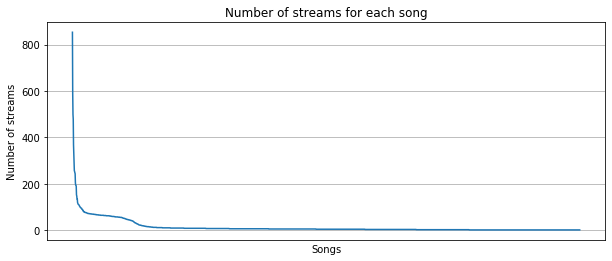

In [25]:
# Plot the n_stream for all songs

ax = track_df['n_stream'].plot(kind = 'line', 
                          figsize = (10,4), 
                          xticks = [], 
                          grid = True, 
                          logy = False,
                          title = 'Number of streams for each song')
                          #xlabel = 'Songs',
                          #ylabel = 'Number of streams')
        
ax.set_xlabel('Songs')
ax.set_ylabel('Number of streams')

Text(0, 0.5, 'Songs')

C:\Users\johnt\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 33310 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\johnt\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 12356 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\johnt\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 33853 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\johnt\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 12385 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\johnt\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 12427 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\johnt\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 33457 missing from c

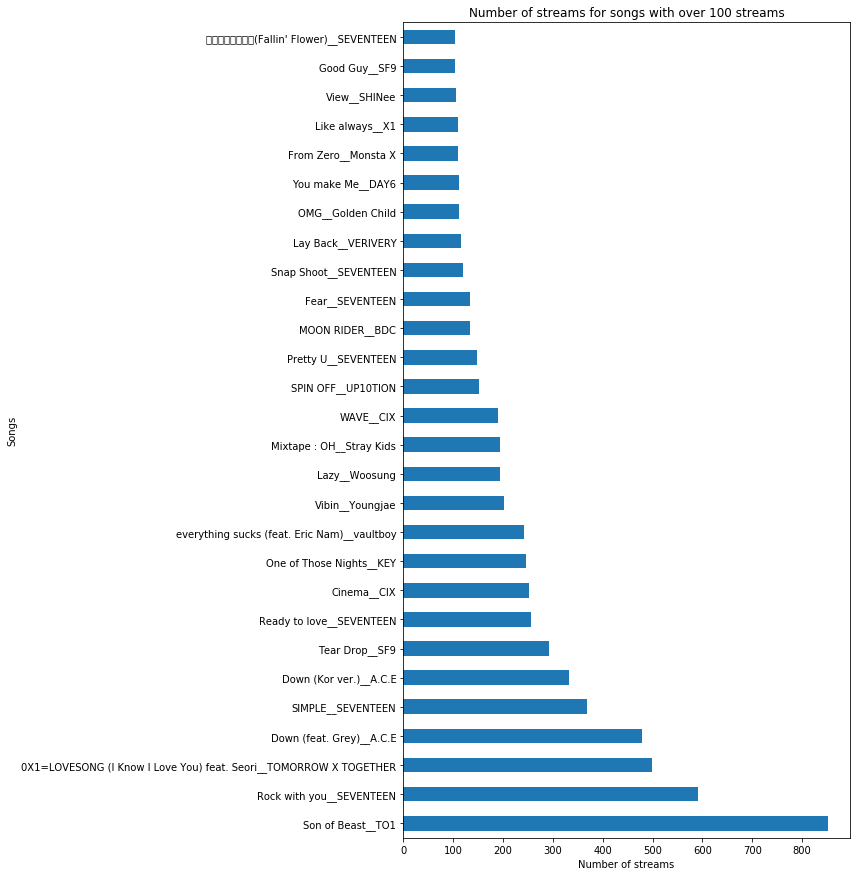

In [26]:
# Plot songs with over 100 streams
ax = track_df[track_df['n_stream'] > 100 ]['n_stream'].plot(kind = 'barh', 
                                                            figsize = (8,15),
                                                            title = 'Number of streams for songs with over 100 streams')

ax.set_xlabel('Number of streams')
ax.set_ylabel('Songs')
#fig = plt.plot(x,y)

Cutoffs for bins:  [0, 5, 10, 25, 50, 75, 100, 853] 

Bin 0
Number of songs with 1-5 streams: 1152

Bin 1
Number of songs with 6-10 streams: 394

Bin 2
Number of songs with 11-25 streams: 90

Bin 3
Number of songs with 26-50 streams: 50

Bin 4
Number of songs with 51-75 streams: 142

Bin 5
Number of songs with 76-100 streams: 23

Bin 6
Number of songs with 101-853 streams: 28



,both,n_stream,bins,binnum
index_both,,,,
Son of Beast__TO1,Son of Beast__TO1,853,bin 6: 101-853 streams,6.0
Rock with you__SEVENTEEN,Rock with you__SEVENTEEN,591,bin 6: 101-853 streams,6.0
0X1=LOVESONG (I Know I Love You) feat. Seori__TOMORROW X TOGETHER,0X1=LOVESONG (I Know I Love You) feat. Seori__...,499,bin 6: 101-853 streams,6.0
Down (feat. Grey)__A.C.E,Down (feat. Grey)__A.C.E,478,bin 6: 101-853 streams,6.0
SIMPLE__SEVENTEEN,SIMPLE__SEVENTEEN,368,bin 6: 101-853 streams,6.0
...,...,...,...,...
BIM BAM BUM__Rocket Punch,BIM BAM BUM__Rocket Punch,1,bin 0: 1-5 streams,0.0
Ridin'__NCT DREAM,Ridin'__NCT DREAM,1,bin 0: 1-5 streams,0.0
Not Fine__DAY6,Not Fine__DAY6,1,bin 0: 1-5 streams,0.0


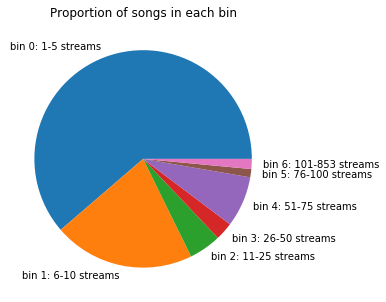

In [27]:
# Bin the n_stream values and create a pie chart
track_pie = track_df[['both', 'n_stream']]

bins = [0,5,10,25,50,75,100,max(track_pie['n_stream'])]
print('Cutoffs for bins: ', bins, '\n')

# Add column to mark the bins
track_pie['bins'] = [0] * len(track_pie)

for i in range(0,len(bins)-1):
    lower = bins[i]
    higher = bins[i+1]
    value = 'bin ' + str(i) + ': ' + str(lower + 1) + '-' + str(higher) + ' streams'
    
    # Bin values (numeric)
    track_pie.loc[( (track_pie['n_stream'] <= higher) & (track_pie['n_stream'] > lower) ), 'binnum'] = i
    
    # Bin values (for labels)
    track_pie.loc[( (track_pie['n_stream'] <= higher) & (track_pie['n_stream'] > lower) ), 'bins'] = value
    
    print('Bin {}\nNumber of songs with {}-{} streams: {}\n'.format(i, 
                                                                    lower + 1, 
                                                                    higher, 
                                                                    len(track_pie[track_pie['bins'] == value])))

# Add the bin column to track_df
track_df['bins'] = track_pie['binnum']
    
# Plot the pie chart
ax = track_pie.groupby('bins').count()['n_stream'].plot(kind = 'pie',
                                                        title = 'Proportion of songs in each bin',
                                                        figsize = (5,5))
ax.set_ylabel('')

track_pie

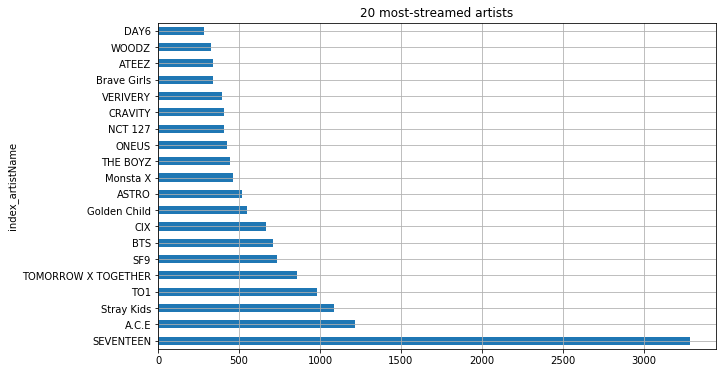

In [28]:
ax = artist_df.sort_values('n_stream', ascending = False)['n_stream'].head(20).plot(kind = 'barh', 
                                                                figsize = (10,6), 
                                                                grid = True, 
                                                                logy = False,
                                                                title = '20 most-streamed artists') 

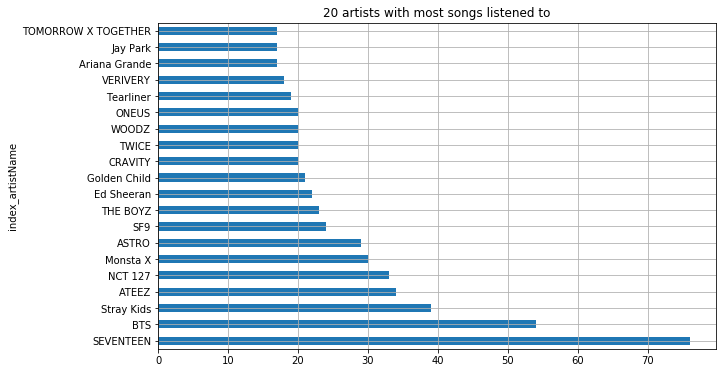

In [29]:
ax = artist_df.sort_values('n_songs', ascending = False)['n_songs'].head(20).plot(kind = 'barh', 
                                                                figsize = (10,6), 
                                                                grid = True, 
                                                                logy = False,
                                                                title = '20 artists with most songs listened to') 

## Probability of listening based on number of streams

For this analysis, I will compare the number of streams for each song to the average number of streams. The data, however, is heavily skewed where most songs fall within a very low number of streams - to account for this, I will compare each song to the mean number of streams within their assigned bins to get one value, and I will compare each song to the mean number of streams for all songs.

The bins I will use will be the same that were assigned to plot the pie chart above:
* Bin 0: 3-5 streams
* Bin 1: 6-10 streams
* Bin 2: 11-25 streams
* Bin 3: 26-50 streams
* Bin 4: 51-75 streams
* Bin 5: 76-100 streams
* Bin 6: More than 100 streams

These bins are arbitrarily chosen but divide the data fairly nicely.The vast majority of songs have below 10 streams, so I felt it was important to divide the lower range into smaller bins.

To add weight to songs with high numbers of streams, I will add the bin number to the score. Ex: a song in bin 5 will have +5 added to the score to account for the fact that it was listened to heavily.

I will define a function that standardizes the values created as at the end of my analysis, I will add up all the values to create a kind of probability of me listening to a song.

In [30]:
# Define standardizing function

def standardize(data, meanval, stdval, weight = 1):
    # Function standardize accepts arguments data and ncol and returns the data in a standardized format using Z-score
    # data: the sequence of data points that will be scaled
    # Note: if stdval = 0, simply return the data as is
    
    output = [weight*(data_val-meanval)/stdval for data_val in data]
    
    return output
    

In [31]:
# Create data frames used to store various standardized comparisons and other useful information
track_compare = track_df.copy()

track_compare

,both,n_stream,bins
index_both,,,
Son of Beast__TO1,Son of Beast__TO1,853,6.0
Rock with you__SEVENTEEN,Rock with you__SEVENTEEN,591,6.0
0X1=LOVESONG (I Know I Love You) feat. Seori__TOMORROW X TOGETHER,0X1=LOVESONG (I Know I Love You) feat. Seori__...,499,6.0
Down (feat. Grey)__A.C.E,Down (feat. Grey)__A.C.E,478,6.0
SIMPLE__SEVENTEEN,SIMPLE__SEVENTEEN,368,6.0
...,...,...,...
BIM BAM BUM__Rocket Punch,BIM BAM BUM__Rocket Punch,1,0.0
Ridin'__NCT DREAM,Ridin'__NCT DREAM,1,0.0
Not Fine__DAY6,Not Fine__DAY6,1,0.0


In [32]:
# Calculate total mean and means within the bins

n_mean_bin = track_df.groupby('bins').mean()['n_stream']
n_mean = track_df['n_stream'].mean()

# Print the values
print('Mean number of streams total: ', n_mean, '\n')
print('Mean number of streams for each bin: ')
for (i,meanval) in enumerate(n_mean_bin):
    print('Bin {}: {}'.format(i, meanval))
    
print('\n')
    
# Calculate standard deviations  
n_std_bin = track_df.groupby('bins').std()['n_stream']
n_std = track_df['n_stream'].std()

# Print the values
print('STD deviation of streams total: ', n_std, '\n')
print('STD deviation of streams for each bin: ')
for (i,stdval) in enumerate(n_std_bin):
    print('Bin {}: {}'.format(i, stdval))
    
    
# Calculate the scaled values from the total mean
scaled_mean_all = standardize(track_df['n_stream'], n_mean, n_std)
track_compare['n_stream'] = track_df['n_stream']#####################################scaled_mean_all 

# Calculate the scaled values from the bin mean
for (i, (mean_val, std_val)) in enumerate(zip(n_mean_bin, n_std_bin)):
    len_mat = len(track_df[track_df['bins']==i])
    scaled_mean = standardize(track_df.loc[track_df['bins'] == i, 'n_stream'], mean_val, std_val, weight=(i+1)) 
    
    track_compare.loc[track_compare['bins'] == i, 'nstream_score'] = scaled_mean
    
# Weight the nstream_score by adding the bin number
#track_compare['nstream_score'] = track_compare['nstream_score']# + track_compare['bins']
    
# Combine results into one column (adding)
track_compare['mean_tot'] = track_compare['n_stream'] + track_compare['nstream_score']
#track_compare = track_compare.sort_values('mean_tot', ascending = False)
    
track_compare.loc[: , ['n_stream', 'bins', 'nstream_score']]

Mean number of streams total:  14.274614156466205 

Mean number of streams for each bin: 
Bin 0: 2.5789930555555554
Bin 1: 7.317258883248731
Bin 2: 15.033333333333333
Bin 3: 39.76
Bin 4: 62.7112676056338
Bin 5: 85.8695652173913
Bin 6: 240.96428571428572


STD deviation of streams total:  39.721154657358134 

STD deviation of streams for each bin: 
Bin 0: 1.4775504042744345
Bin 1: 1.2933010406181138
Bin 2: 3.975910608720893
Bin 3: 7.280278083946514
Bin 4: 5.874069699593365
Bin 5: 8.508307960330669
Bin 6: 177.46475542481502


,n_stream,bins,nstream_score
index_both,,,
Son of Beast__TO1,853,6.0,24.141413
Rock with you__SEVENTEEN,591,6.0,13.806967
0X1=LOVESONG (I Know I Love You) feat. Seori__TOMORROW X TOGETHER,499,6.0,10.178077
Down (feat. Grey)__A.C.E,478,6.0,9.349744
SIMPLE__SEVENTEEN,368,6.0,5.010854
...,...,...,...
BIM BAM BUM__Rocket Punch,1,0.0,-1.068656
Ridin'__NCT DREAM,1,0.0,-1.068656
Not Fine__DAY6,1,0.0,-1.068656


In [33]:
# Save the general stats in a template

template_compare = track_compare[['both', 'bins', 'n_stream', 'nstream_score']]

In [34]:
# See the top and bottom 20
displaynum = 20

track_compare_stats = pd.DataFrame({'nstream_score_head':track_compare['nstream_score'].head(displaynum).index,
                                    'nstream_score_tail':track_compare['nstream_score'].tail(displaynum).loc[::-1].index})

track_compare_stats
#track_compare['m_tot'].tail(displaynum).loc[::-1]

,nstream_score_head,nstream_score_tail
0,Son of Beast__TO1,you broke me first__Tate McRae
1,Rock with you__SEVENTEEN,Ghost__BAEKHYUN
2,0X1=LOVESONG (I Know I Love You) feat. Seori__...,Not Fine__DAY6
3,Down (feat. Grey)__A.C.E,Ridin'__NCT DREAM
4,SIMPLE__SEVENTEEN,BIM BAM BUM__Rocket Punch
5,Down (Kor ver.)__A.C.E,Remember__KATIE
6,Tear Drop__SF9,DIFFERENT__WOODZ
7,Ready to love__SEVENTEEN,HOLIDAY__Lil Nas X
8,Cinema__CIX,Panini__Lil Nas X
9,One of Those Nights__KEY,1993__Manila Killa


### Artists: Stream score

To determine the artist stream number score, I multiply the number of streams by the number of songs. This highlights artists whose music I most listen to, whether that's the number of songs listened to or total stream time. 

In [35]:
temp = artist_df.copy()
temp['nstreamXnsong'] = temp['n_stream'] * temp['n_songs']
meanval = temp['nstreamXnsong'].mean()
stdval = temp['nstreamXnsong'].std()
artist_df['nstreamXnsong'] = standardize(temp['nstreamXnsong'], meanval, stdval)

artist_df.sort_values('nstreamXnsong', ascending = False)

,artistName,n_stream,n_songs,weight,nstreamXnsong
index_artistName,,,,,
SEVENTEEN,SEVENTEEN,3282,76,74.279929,22.392283
Stray Kids,Stray Kids,1085,39,37.646797,3.718158
BTS,BTS,710,54,50.183246,3.359763
A.C.E,A.C.E,1217,15,14.817370,1.548855
SF9,SF9,735,24,23.241107,1.493406
...,...,...,...,...,...
Perk,Perk,1,1,0.500000,-0.096966
Jessie Ware,Jessie Ware,1,1,0.500000,-0.096966
JayWay,JayWay,1,1,0.500000,-0.096966


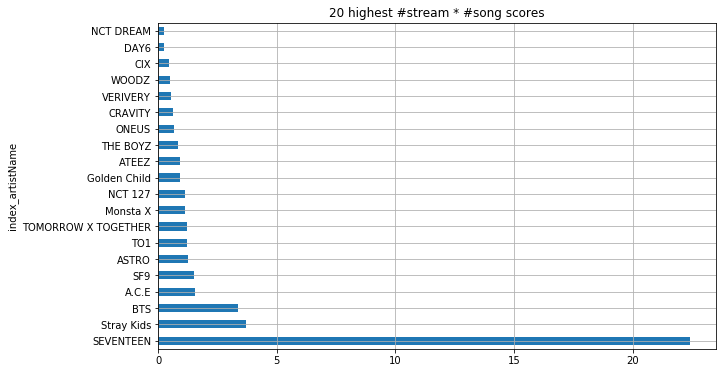

In [36]:
ax = artist_df.sort_values('nstreamXnsong', ascending = False)['nstreamXnsong'].head(20).plot(kind = 'barh', 
                                                                            figsize = (10,6), 
                                                                            grid = True, 
                                                                            logy = False,
                                                                            title = '20 highest #stream * #song scores') 

In [37]:
# See how many songs were at the bottom
#min_tracks = len(track_compare[track_compare['m_tot'] == track_compare['m_tot'].min()])
#print('Number of tracks with the lowest score for number of streams: ', min_tracks)
#print('\n', track_compare[track_compare['m_tot'] == track_compare['m_tot'].min()][['both']].values)

#track_compare[track_compare['m_tot'] == track_compare['m_tot'].min()]

# Analysis: Stream lengths

I will perform a similar analysis to the previous examination of number of streams - This time, I will focus on stream lengths. If I enjoy a song, it would make sense for the song to, on average, have longer stream lengths.

For this analysis, I will extract certain useful pieces of information:
* Mean stream length: Average length of song streams for all tracks
* Longest stream length: The longest stream length recorded for songs - in theory this should be the actual track length but it may simply just be the longest amount of time played
* Total streamtime: The total amount of stream time that a song has been played

However, if I use stream  times as is, this analysis
To avoid bias for longer somgs, I will normalize the times by converting the stream lengths into percentages of a song completed (from 0 to 1). I will use the highest stream length available for a song as a full listen and calculate the percentages of that accordingly. I will then compare the longest stream to the average longest stream for each song to weight against songs most likely not fully listened to (ex: Elevator(127F) by NCT 127 has a longest stream time of 35.6s, likely far below the amount

I will use the longest stream for the song unless the longest stream length falls below 1 std deviation below the mean, in which I will use the mean as the song length. This is such that a song that is regularly skipped and thus has a very low longest stream length doesn't get a similar score to a song regularly fully listened to

ex: If song 1 has 5 plays, 4 plays at 8 seconds and 1 play at 10 seconds, it will be ranked similarly to song 2 with 5 plays, 4 plays at 160 seconds and 1 play at 200 seconds. 

In [38]:
template_track

,both,trackName,artistName,n_stream,song_length,mode_exists
index_both,,,,,,
Then We__jeebanoff,Then We__jeebanoff,Then We,jeebanoff,1,165.916,0
Chain - Korean Version__NCT 127,Chain - Korean Version__NCT 127,Chain - Korean Version,NCT 127,5,223.6,1
90's Love__NCT U,90's Love__NCT U,90's Love,NCT U,16,213.666,1
AH! LOVE__SEVENTEEN,AH! LOVE__SEVENTEEN,AH! LOVE,SEVENTEEN,8,194.626,1
tomorrow tonight__Loote,tomorrow tonight__Loote,tomorrow tonight,Loote,7,202.6,1
...,...,...,...,...,...,...
I.F.L.Y.__Bazzi,I.F.L.Y.__Bazzi,I.F.L.Y.,Bazzi,1,165.916,0
Beautiful (feat. Camila Cabello)__Bazzi,Beautiful (feat. Camila Cabello)__Bazzi,Beautiful (feat. Camila Cabello),Bazzi,1,165.916,0
THATS WHAT I WANT__Lil Nas X,THATS WHAT I WANT__Lil Nas X,THATS WHAT I WANT,Lil Nas X,1,165.916,0


In [39]:
#temp_spotify.sort_values('per_complete').isnull().sum()

In [40]:
# Assign stream_df as the template
stream_df = template_track.copy()

# Extract only needed columns from spotify_df3
stream_spotify = template_spot[['both', 'sPlayed']]

# Calculate total mean and total std deviation of sPlayed column
all_mean = stream_df['song_length'].mean()
all_std = stream_df['song_length'].std()

print('Mean stream length: {:.2f}s ({}min {}s)'.format(all_mean,
                                                                  math.floor(all_mean/60),
                                                                  math.floor(all_mean%60)))
print('Std deviation of stream length: {:.2f}s ({}min {}s)'.format(all_std,
                                                                              math.floor(all_std/60),
                                                                              math.floor(all_std%60)))
print('\nDefault stream length for songs with very short streams: {:.2f}s ({}min {}s)'.format(all_mean,
                                                                                 math.floor(all_mean/60), 
                                                                                 math.floor(all_mean%60)))
print('Minimum stream length is 1 standard deviations below the mean song length')



# For each song, add all stream lengths and divide by song_length for total full streams played
# ALSO, divide each stream length by the song length and place into another column
for song in stream_df['both']:
    index = stream_spotify['both'] == song
    songlength = stream_df.loc[song, 'song_length']
    
    # Calculate percentage of song streamed and record in per_complete column
    stream_spotify.loc[index, 'per_complete'] = stream_spotify[index]['sPlayed'] / songlength
    
    #print(temp_spotify.loc[index, 'per_complete'])
    

# Calculate the average percentage of a song streamed for each song, record as per_stream in stream_df
stream_df['per_stream'] = stream_spotify.groupby('both')['per_complete'].mean()

# Scale the percentages to the range of -3 to 3 for perstream_score
r1 = [-3,0]
r2 = [0,3]

r1min = r1[0]
r1max = r1[1]
r2min = r2[0]
r2max = r2[1]
range1 = r1max - r1min
range2 = r2max - r2min

score1 = stream_df[stream_df['per_stream'] <= .75]['per_stream']
score2 = stream_df[stream_df['per_stream'] >= .75]['per_stream']

stream_df.loc[stream_df['per_stream'] <= .75, 'perstream_score'] = (range1 * (score1 - min(score1)) / 
                                                                    (max(score1)-min(score1))) + r1min
stream_df.loc[stream_df['per_stream'] >= .75, 'perstream_score'] = (range2 * (score2 - min(score2)) / 
                                                                    (max(score2)-min(score2))) + r2min



# Weight the percentage with the amount of streams (to remove bias toward songs with few but complete listens)
#stream_df['per_stream_weight'] = stream_df['per_stream'] * stream_df['n_stream']
#weightedper_mean = stream_df['per_stream_weight'].mean()
#weightedper_std = stream_df['per_stream_weight'].std()

#stream_df['per_stream_weight'] = standardize(stream_df['per_stream_weight'], weightedper_mean, weightedper_std)



stream_df.sort_values('perstream_score')



Mean stream length: 196.52s (3min 16s)
Std deviation of stream length: 32.44s (0min 32s)

Default stream length for songs with very short streams: 196.52s (3min 16s)
Minimum stream length is 1 standard deviations below the mean song length


C:\Users\johnt\anaconda3\lib\site-packages\pandas\core\indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\johnt\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,both,trackName,artistName,n_stream,song_length,mode_exists,per_stream,perstream_score
index_both,,,,,,,,
La Di Da__Lennon Stella,La Di Da__Lennon Stella,La Di Da,Lennon Stella,1,165.916,0,0.000139,-3.000000
Pyramid__P1Harmony,Pyramid__P1Harmony,Pyramid,P1Harmony,1,165.916,0,0.000139,-3.000000
Be Fine__Madeon,Be Fine__Madeon,Be Fine,Madeon,1,165.916,0,0.000139,-3.000000
All Too Well (10 Minute Version) (Taylor's Version) (From The Vault)__Taylor Swift,All Too Well (10 Minute Version) (Taylor's Ver...,All Too Well (10 Minute Version) (Taylor's Ver...,Taylor Swift,1,165.916,0,0.000350,-2.999156
Kuyenda__Lennart Schroot,Kuyenda__Lennart Schroot,Kuyenda,Lennart Schroot,1,165.916,0,0.001248,-2.995563
...,...,...,...,...,...,...,...,...
Rewind__ONEUS,Rewind__ONEUS,Rewind,ONEUS,8,193.706,1,1.049049,1.909679
Believe__Paul Blanco,Believe__Paul Blanco,Believe,Paul Blanco,5,187.35,1,1.051656,1.926332
Shhh__SEVENTEEN,Shhh__SEVENTEEN,Shhh,SEVENTEEN,5,186.974,1,1.079048,2.101255


To calculate the stream score, I transformed the percentage of the song streamed to fit the range of -3 to +3.

* 75% <= x <= 100% completion will be scaled from 0 - 3
* 0% < x < 75% completion will be scaled from -3 - 0

In [41]:
stream_df[stream_df['artistName'] == 'UP10TION']
stream_spotify[stream_spotify['both'] == 'Light__UP10TION']

,both,sPlayed,per_complete
3303,Light__UP10TION,338.743,1.62847
5102,Light__UP10TION,208.013,1.00000
9346,Light__UP10TION,208.013,1.00000


## Visualize the data

C:\Users\johnt\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 45320 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\johnt\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 45572 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\johnt\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 44396 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\johnt\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 45768 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\johnt\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 45320 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\johnt\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 45572 missing from cur

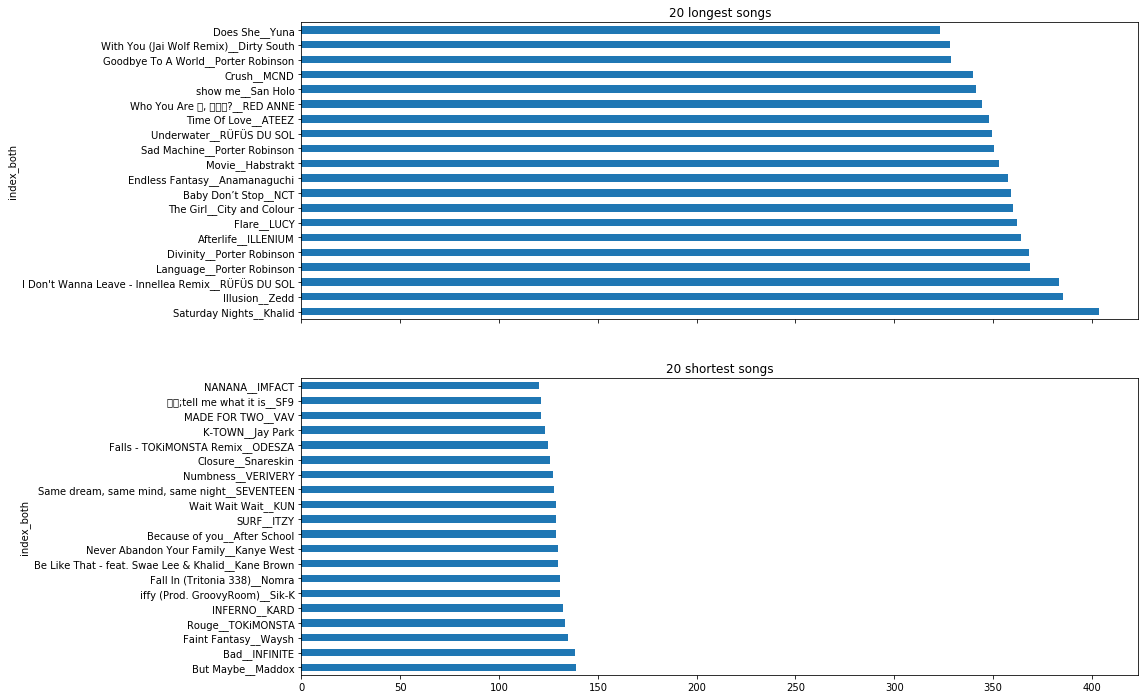

In [42]:
# Bar charts for song length
stream_bar = stream_df[['song_length','per_stream']]


length_high20 = stream_bar['song_length'].sort_values(ascending = False).head(20)
length_low20 = stream_bar['song_length'].sort_values(ascending = False).tail(20)

fig, axes = plt.subplots(nrows = 2, ncols = 1, sharex = True, figsize = (15,12))


length_high20.plot(kind = 'barh', title = '20 longest songs', ax = axes[0])
length_low20.plot(kind = 'barh', title = '20 shortest songs', ax = axes[1])

#ax.set_xlabel('')


C:\Users\johnt\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\johnt\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 45824 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\johnt\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 45813 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\johnt\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 51008 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\johnt\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 45236 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\johnt\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 45796 missing from c

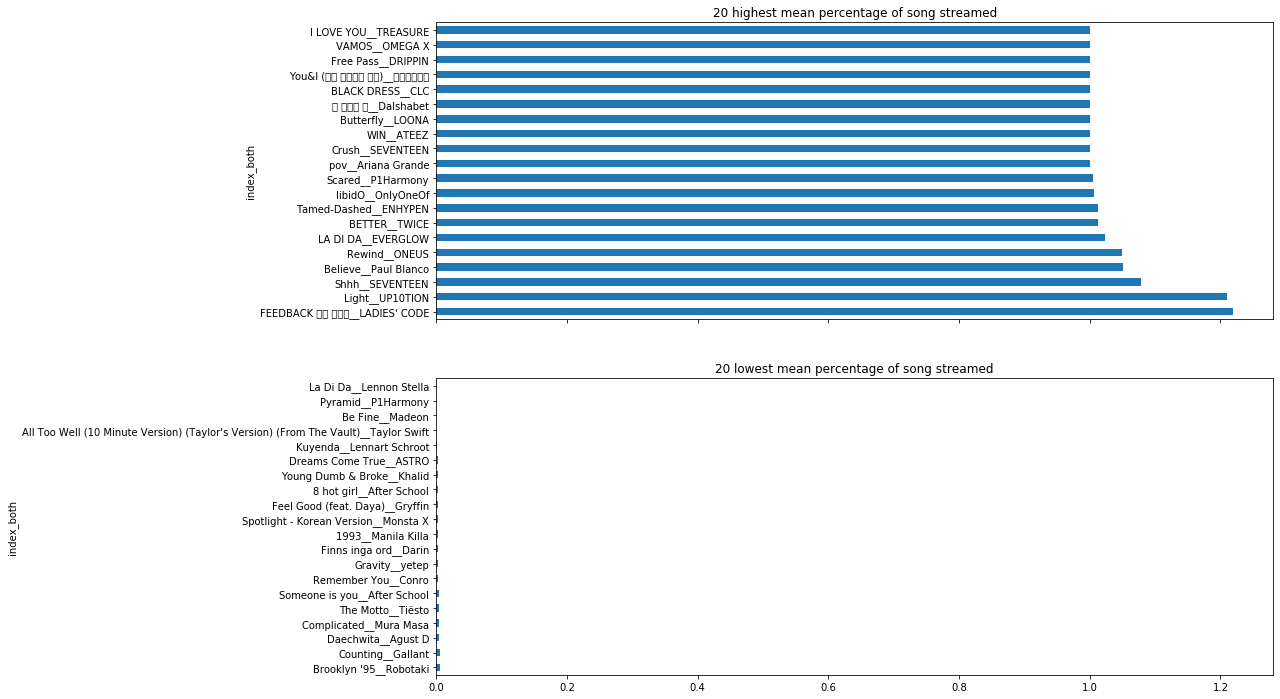

In [43]:
# Plot the 20 highest mean percentages of songs streamed
stream_bar = stream_df[['per_stream']]


per_high20 = stream_bar['per_stream'].sort_values(ascending = False).head(20)
per_low20 = stream_bar['per_stream'].sort_values(ascending = False).tail(20)

fig, axes = plt.subplots(nrows = 2, ncols = 1, sharex = True, figsize = (15,12))


per_high20.plot(kind = 'barh', 
                title = '20 highest mean percentage of song streamed', 
                ax = axes[0])
per_low20.plot(kind = 'barh', 
                title = '20 lowest mean percentage of song streamed', 
                ax = axes[1])


In [44]:
# Print number of songs with 100% stream rate
print('Number of songs with 100% stream rate: ', sum(stream_df['per_stream'] == 1), '\n')

stream_df.loc[stream_df['per_stream'] == 1, ['trackName','artistName','n_stream','per_stream']].sort_values('n_stream')

#for song in stream_df.loc[stream_df['per_stream'] == 1, 'both']:
#    print(song)

Number of songs with 100% stream rate:  177 



,trackName,artistName,n_stream,per_stream
index_both,,,,
Too Much__Kehlani,Too Much,Kehlani,1,1.0
BAD SAD AND MAD__BIBI,BAD SAD AND MAD,BIBI,1,1.0
Nancy Mulligan__Ed Sheeran,Nancy Mulligan,Ed Sheeran,1,1.0
OXYGEN__TWICE,OXYGEN,TWICE,1,1.0
Lock Down__EPEX,Lock Down,EPEX,1,1.0
...,...,...,...,...
MY I__SEVENTEEN,MY I,SEVENTEEN,5,1.0
Killing Me__CHUNG HA,Killing Me,CHUNG HA,5,1.0
Pirate__EVERGLOW,Pirate,EVERGLOW,5,1.0


C:\Users\johnt\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 45320 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\johnt\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\johnt\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 45824 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\johnt\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 45813 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\johnt\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 51008 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\johnt\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 45236 missing from c

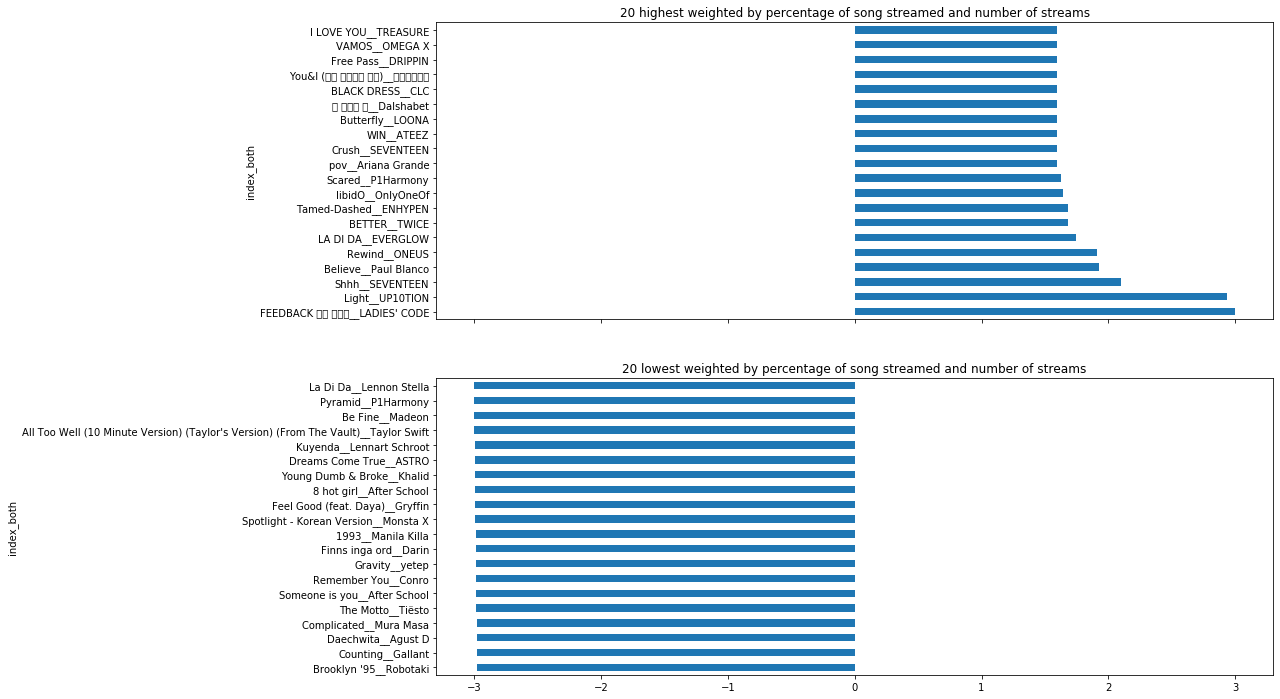

In [45]:
# Plot the 20 highest stream scores
stream_bar = stream_df[['perstream_score']]


per_high20 = stream_bar['perstream_score'].sort_values(ascending = False).head(20)
per_low20 = stream_bar['perstream_score'].sort_values(ascending = False).tail(20)

fig, axes = plt.subplots(nrows = 2, ncols = 1, sharex = True, figsize = (15,12))


per_high20.plot(kind = 'barh', 
                title = '20 highest weighted by percentage of song streamed and number of streams', 
                ax = axes[0])
per_low20.plot(kind = 'barh', 
                title = '20 lowest weighted by percentage of song streamed and number of streams', 
                ax = axes[1])


## Add relevant results to template_compare

In [46]:
template_compare['perstream_score'] = stream_df['perstream_score']

template_compare

,both,bins,n_stream,nstream_score,perstream_score
index_both,,,,,
Son of Beast__TO1,Son of Beast__TO1,6.0,853,24.141413,1.515124
Rock with you__SEVENTEEN,Rock with you__SEVENTEEN,6.0,591,13.806967,1.522948
0X1=LOVESONG (I Know I Love You) feat. Seori__TOMORROW X TOGETHER,0X1=LOVESONG (I Know I Love You) feat. Seori__...,6.0,499,10.178077,1.418093
Down (feat. Grey)__A.C.E,Down (feat. Grey)__A.C.E,6.0,478,9.349744,1.393549
SIMPLE__SEVENTEEN,SIMPLE__SEVENTEEN,6.0,368,5.010854,1.342110
...,...,...,...,...,...
BIM BAM BUM__Rocket Punch,BIM BAM BUM__Rocket Punch,0.0,1,-1.068656,1.596461
Ridin'__NCT DREAM,Ridin'__NCT DREAM,0.0,1,-1.068656,1.596461
Not Fine__DAY6,Not Fine__DAY6,0.0,1,-1.068656,-2.945766


### Artists: Percentage of song completed per stream

In [47]:
temp = artist_df.copy()

# Calculate percentage of songs streamed on average (extrapolated from the song_stream analysis)
artist_df['song_perstream'] = stream_df.groupby('artistName')['per_stream'].mean() * artist_df['weight'] 


# Scale the percentages to the range of -3 to 3 for perstream_score
r1 = [-3,0]
r2 = [0,3]

r1min = r1[0]
r1max = r1[1]
r2min = r2[0]
r2max = r2[1]
range1 = r1max - r1min
range2 = r2max - r2min

score1 = artist_df[artist_df['song_perstream'] <= .75]['song_perstream'] 
score2 = artist_df[artist_df['song_perstream'] >= .75]['song_perstream'] 

artist_df.loc[artist_df['song_perstream'] <= .75, 'perstream_score'] = (range1 * (score1 - min(score1)) / 
                                                                    (max(score1)-min(score1))) + r1min
artist_df.loc[artist_df['song_perstream'] >= .75, 'perstream_score'] = ((range2 * (score2 - min(score2)) / 
                                                                    (max(score2)-min(score2))) + r2min) 

artist_df.sort_values('perstream_score', ascending = False)

,artistName,n_stream,n_songs,weight,nstreamXnsong,song_perstream,perstream_score
index_artistName,,,,,,,
SEVENTEEN,SEVENTEEN,3282,76,74.279929,22.392283,51.657735,3.000000
BTS,BTS,710,54,50.183246,3.359763,27.283907,1.563647
Stray Kids,Stray Kids,1085,39,37.646797,3.718158,24.529034,1.401302
ATEEZ,ATEEZ,336,34,30.875676,0.932957,17.052010,0.960680
NCT 127,NCT 127,409,33,30.536199,1.119864,17.049726,0.960545
...,...,...,...,...,...,...,...
Olly Murs,Olly Murs,1,1,0.500000,-0.096966,0.003194,-2.987499
Darin,Darin,4,1,0.800000,-0.096695,0.002200,-2.991477
Tiësto,Tiësto,1,1,0.500000,-0.096966,0.002125,-2.991778


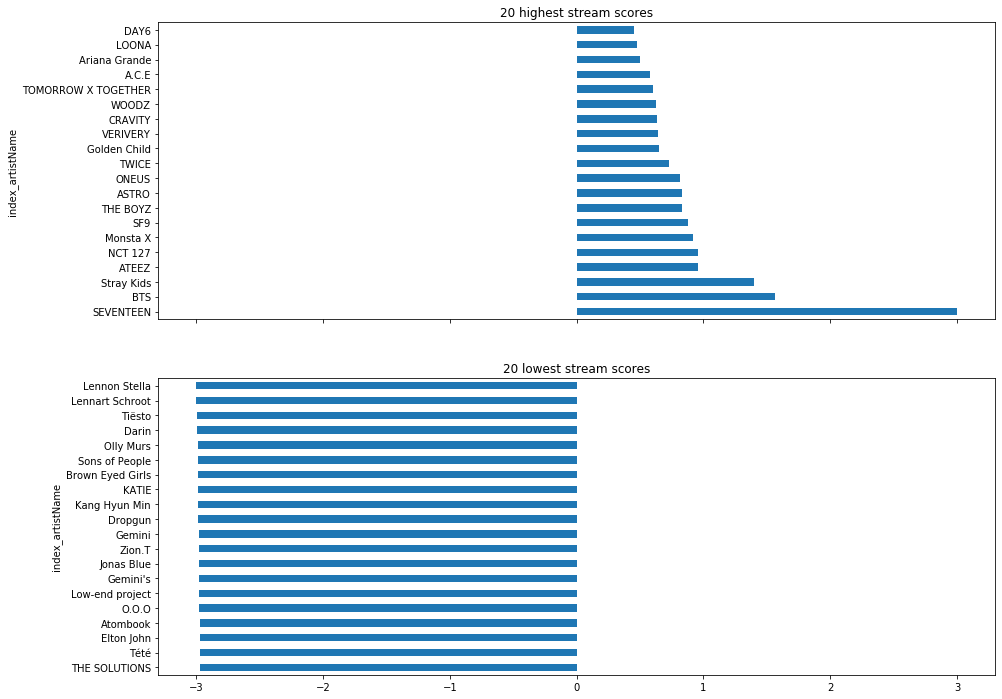

In [48]:
# Plot the 20 highest stream scores
artist_bar = artist_df[['perstream_score']]


per_high20 = artist_bar['perstream_score'].sort_values(ascending = False).head(20)
per_low20 = artist_bar['perstream_score'].sort_values(ascending = False).tail(20)

fig, axes = plt.subplots(nrows = 2, ncols = 1, sharex = True, figsize = (15,12))


per_high20.plot(kind = 'barh', 
                title = '20 highest stream scores', 
                ax = axes[0])
per_low20.plot(kind = 'barh', 
                title = '20 lowest stream scores', 
                ax = axes[1])


# Number of skips
For this analysis, I will look at the amount of times each song was skipped. I will use 3 intervals:

* 10 seconds: If the song was skipped before 10 seconds, the song was likely instantly skipped
* 30 seconds: The amount of time a song should be streamed for the artist to receive royalties
* 90 seconds: In general, this time is after the first chorus has finished
* End of song: If the stream time is within 10 seconds of the song length, I will consider it finished

These are arbitrarily chosen but provide insight in the skip. A stream length of less than 10 seconds indicates that the song was likely instantly skipped. Less than 30 seconds indicates some kind of hesitancy before skipping. Less than 90 seconds indicates that the song was likely listened to up through the first chorus and then skipped. End of song is fairly self-explanatory: The song was not fully streamed. A 10 second gap is in place to account for outros - sometimes songs are skipped during the outro, but I will consider that to be completed.

I will use different weights to emphasize severity of skipping:

* 10 seconds: Weight = 3
* 30 seconds: Weight = 1
* 90 seconds: Weight = 2
* Unfinished song: Weight = 1

I will then compare the weighted sum of skips to the number of full streams by summing up the weighted skip totals and dividing by the number of skip streams and subtracting them from the unweighted sum of complete streams. To normalize the scores, I will then divide the weighted skip sum 

$(N_{10s}*3) + (N_{30s}*1) + (N_{90s}*2) + (N_{Unfinished}*1) = WeightedSkipSum_{Mean}$


$\frac{N_{CompletedStreams}}{N_{Streams}} - \frac{WeightedSkipSum}{N_{skips}} = SkipScore$




In [49]:
# Create skip_df and skip_spotify
skip_df = template_track.copy()
skip_spotify = template_spot.copy()

In [50]:
# Add columns to skip_spotify to mark skips at the desired intervals

# Create weights to punish certain skips
skip_weights = [5, 1, 3, 2]

# Initialize columns at 0
zero_list = [0] * len(skip_spotify)

skip_spotify['skip10'] = 0
skip_spotify['skip30'] = 0
skip_spotify['skip90'] = 0
skip_spotify['morethan10'] = 0
skip_spotify['noskip'] = 0

# Populate skip10 column
skip_spotify.loc[skip_spotify['sPlayed'] < 10, 'skip10'] = -1
# Populate skip30 column
skip_spotify.loc[skip_spotify['sPlayed'] < 30, 'skip30'] = -1
# Populate skip90 column
skip_spotify.loc[skip_spotify['sPlayed'] < 90, 'skip90'] = -1

# Populate morethan10 column and noskip column
for (song, songlength) in zip(skip_df['both'], skip_df['song_length']):
    condition_morethan10 = ( (skip_spotify['both'] == song) & ((songlength-skip_spotify['sPlayed']) > 10))
    skip_spotify.loc[condition_morethan10, 'morethan10'] = -1
    
    condition_noskip = ( (skip_spotify['both'] == song) & ((songlength-skip_spotify['sPlayed']) <= 10))
    skip_spotify.loc[condition_noskip, 'noskip'] = 1



In [51]:
# Sum up the columns and add to skip_df
temp = skip_spotify.groupby('both')[['skip10','skip30','skip90','morethan10', 'noskip']].sum()
skip_df['skip10'] = temp.loc[:,'skip10']
skip_df['skip30'] = temp.loc[:,'skip30']
skip_df['skip90'] = temp.loc[:,'skip90']
skip_df['morethan10'] = temp.loc[:,'morethan10']
skip_df['noskip'] = temp.loc[:,'noskip']

# Convert to percentages of n_stream
skip_df['skip10_w'] = skip_df['skip10'] / skip_df['n_stream']
skip_df['skip30_w'] = skip_df['skip30'] / skip_df['n_stream']
skip_df['skip90_w'] = skip_df['skip90'] / skip_df['n_stream']
skip_df['morethan10_w'] = skip_df['morethan10'] / skip_df['n_stream']
skip_df['noskip_w'] = skip_df['noskip'] / skip_df['n_stream']

# Sum all values in skip_df and add to 'tot'
skip_df['tot'] = skip_df['skip10'] + skip_df['skip30'] + skip_df['skip90'] + skip_df['morethan10'] + skip_df['noskip']

# Weight skips according to severity and add to 'tot_w'
skip_df['tot_w'] = (skip_df['skip10'] * skip_weights[0] + 
                    skip_df['skip30'] * skip_weights[1] + 
                    skip_df['skip90'] * skip_weights[2] + 
                    skip_df['morethan10'] * skip_weights[3])

# Compure skip_per = Percent of streams that are skipped
skip_df['skip_per'] = (skip_df['morethan10'] / skip_df['n_stream']) * -1

# Compute skip_score - NOTE: +1 in the noskip denominator to avoid division by 0 for songs with no skips
skip_df['skip_score'] = ((skip_df['tot_w']/(-1*skip_df['morethan10'] + 1)) + 
                         (skip_df['noskip'] / skip_df['n_stream']))

# Repeat sum and skip score for percentages
skip_df['skip_score_w'] = (skip_df['skip10_w'] * skip_weights[0] + 
                      skip_df['skip30_w'] * skip_weights[1] + 
                      skip_df['skip90_w'] * skip_weights[2] + 
                      skip_df['morethan10_w'] * skip_weights[3] +
                      skip_df['noskip_w'])


# Standardize the skip score
#skip_df['std_tot_w'] = standardize(skip_df['tot_w'], skip_df['tot_w'].mean(), skip_df['tot_w'].std())

skip_df

,both,trackName,artistName,n_stream,song_length,mode_exists,skip10,skip30,skip90,morethan10,...,skip10_w,skip30_w,skip90_w,morethan10_w,noskip_w,tot,tot_w,skip_per,skip_score,skip_score_w
index_both,,,,,,,,,,,,,,,,,,,,,
Then We__jeebanoff,Then We__jeebanoff,Then We,jeebanoff,1,165.916,0,-1,-1,-1,-1,...,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-4,-11,1.000000,-5.500000,-11.000000
Chain - Korean Version__NCT 127,Chain - Korean Version__NCT 127,Chain - Korean Version,NCT 127,5,223.6,1,-2,-2,-2,-3,...,-0.400000,-0.400000,-0.400000,-0.600000,0.400000,-7,-24,0.600000,-5.600000,-4.400000
90's Love__NCT U,90's Love__NCT U,90's Love,NCT U,16,213.666,1,-3,-4,-4,-6,...,-0.187500,-0.250000,-0.250000,-0.375000,0.625000,-7,-43,0.375000,-5.517857,-2.062500
AH! LOVE__SEVENTEEN,AH! LOVE__SEVENTEEN,AH! LOVE,SEVENTEEN,8,194.626,1,0,-1,-2,-3,...,0.000000,-0.125000,-0.250000,-0.375000,0.625000,-1,-13,0.375000,-2.625000,-1.000000
tomorrow tonight__Loote,tomorrow tonight__Loote,tomorrow tonight,Loote,7,202.6,1,-1,-2,-2,-3,...,-0.142857,-0.285714,-0.285714,-0.428571,0.571429,-4,-19,0.428571,-4.178571,-2.142857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
I.F.L.Y.__Bazzi,I.F.L.Y.__Bazzi,I.F.L.Y.,Bazzi,1,165.916,0,0,-1,-1,-1,...,0.000000,-1.000000,-1.000000,-1.000000,0.000000,-3,-6,1.000000,-3.000000,-6.000000
Beautiful (feat. Camila Cabello)__Bazzi,Beautiful (feat. Camila Cabello)__Bazzi,Beautiful (feat. Camila Cabello),Bazzi,1,165.916,0,0,-1,-1,-1,...,0.000000,-1.000000,-1.000000,-1.000000,0.000000,-3,-6,1.000000,-3.000000,-6.000000
THATS WHAT I WANT__Lil Nas X,THATS WHAT I WANT__Lil Nas X,THATS WHAT I WANT,Lil Nas X,1,165.916,0,-1,-1,-1,-1,...,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-4,-11,1.000000,-5.500000,-11.000000


In [52]:
skip_df.sort_values('skip_score_w', ascending = False)

,both,trackName,artistName,n_stream,song_length,mode_exists,skip10,skip30,skip90,morethan10,...,skip10_w,skip30_w,skip90_w,morethan10_w,noskip_w,tot,tot_w,skip_per,skip_score,skip_score_w
index_both,,,,,,,,,,,,,,,,,,,,,
Why Try__Ariana Grande,Why Try__Ariana Grande,Why Try,Ariana Grande,1,211.88,1,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,1,0,-0.0,1.0,1.0
Out Of Control__THE BOYZ,Out Of Control__THE BOYZ,Out Of Control,THE BOYZ,1,155.813,1,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,1,0,-0.0,1.0,1.0
+Hwa+__CL,+Hwa+__CL,+Hwa+,CL,1,176.349,1,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,1,0,-0.0,1.0,1.0
Still Learning__Halsey,Still Learning__Halsey,Still Learning,Halsey,2,211.784,1,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,2,0,-0.0,1.0,1.0
ECLIPSE__GOT7,ECLIPSE__GOT7,ECLIPSE,GOT7,1,209.519,1,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,1,0,-0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Giggle Bee__Atombook,Giggle Bee__Atombook,Giggle Bee,Atombook,1,165.916,0,-1,-1,-1,-1,...,-1.0,-1.0,-1.0,-1.0,0.0,-4,-11,1.0,-5.5,-11.0
The End Is Near__Tearliner,The End Is Near__Tearliner,The End Is Near,Tearliner,1,165.916,0,-1,-1,-1,-1,...,-1.0,-1.0,-1.0,-1.0,0.0,-4,-11,1.0,-5.5,-11.0
Wnadering Wave__Tearliner,Wnadering Wave__Tearliner,Wnadering Wave,Tearliner,1,165.916,0,-1,-1,-1,-1,...,-1.0,-1.0,-1.0,-1.0,0.0,-4,-11,1.0,-5.5,-11.0


In [53]:
# Add the standardized weighted sum to template_compare
template_compare['skip_score'] = skip_df['skip_score_w']

template_compare

,both,bins,n_stream,nstream_score,perstream_score,skip_score
index_both,,,,,,
Son of Beast__TO1,Son of Beast__TO1,6.0,853,24.141413,1.515124,0.819461
Rock with you__SEVENTEEN,Rock with you__SEVENTEEN,6.0,591,13.806967,1.522948,0.796954
0X1=LOVESONG (I Know I Love You) feat. Seori__TOMORROW X TOGETHER,0X1=LOVESONG (I Know I Love You) feat. Seori__...,6.0,499,10.178077,1.418093,0.667335
Down (feat. Grey)__A.C.E,Down (feat. Grey)__A.C.E,6.0,478,9.349744,1.393549,0.640167
SIMPLE__SEVENTEEN,SIMPLE__SEVENTEEN,6.0,368,5.010854,1.342110,0.510870
...,...,...,...,...,...,...
BIM BAM BUM__Rocket Punch,BIM BAM BUM__Rocket Punch,0.0,1,-1.068656,1.596461,1.000000
Ridin'__NCT DREAM,Ridin'__NCT DREAM,0.0,1,-1.068656,1.596461,1.000000
Not Fine__DAY6,Not Fine__DAY6,0.0,1,-1.068656,-2.945766,-11.000000


In [54]:
skip_spotify

,endTime,artistName,trackName,sPlayed,both,skip10,skip30,skip90,morethan10,noskip
0,2020-12-04 00:53:00,jeebanoff,Then We,4.449,Then We__jeebanoff,-1,-1,-1,-1,0
1,2020-12-04 18:36:00,NCT 127,Chain - Korean Version,6.906,Chain - Korean Version__NCT 127,-1,-1,-1,-1,0
2,2020-12-04 18:39:00,NCT U,90's Love,212.384,90's Love__NCT U,0,0,0,0,1
3,2020-12-04 18:43:00,SEVENTEEN,AH! LOVE,194.626,AH! LOVE__SEVENTEEN,0,0,0,0,1
4,2020-12-04 18:45:00,Loote,tomorrow tonight,129.696,tomorrow tonight__Loote,0,0,0,-1,0
...,...,...,...,...,...,...,...,...,...,...
27050,2021-12-04 23:45:00,CRAVITY,Flame,194.333,Flame__CRAVITY,0,0,0,0,1
27051,2021-12-04 23:48:00,YUNHWAY,Colors,206.226,Colors__YUNHWAY,0,0,0,0,1
27052,2021-12-04 23:52:00,OH MY GIRL,Dun Dun Dance,220.560,Dun Dun Dance__OH MY GIRL,0,0,0,0,1
27053,2021-12-04 23:55:00,HA SUNG WOON,Sneakers,194.520,Sneakers__HA SUNG WOON,0,0,0,0,1


In [55]:
skip_df.sort_values('tot_w', ascending=False)

,both,trackName,artistName,n_stream,song_length,mode_exists,skip10,skip30,skip90,morethan10,...,skip10_w,skip30_w,skip90_w,morethan10_w,noskip_w,tot,tot_w,skip_per,skip_score,skip_score_w
index_both,,,,,,,,,,,,,,,,,,,,,
What a Wonderful Word__PARKMOONCHI,What a Wonderful Word__PARKMOONCHI,What a Wonderful Word,PARKMOONCHI,2,201.893,1,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,1.000000,2,0,-0.000000,1.000000,1.000000
Good Thing (with Kehlani)__Zedd,Good Thing (with Kehlani)__Zedd,Good Thing (with Kehlani),Zedd,2,210.901,1,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,1.000000,2,0,-0.000000,1.000000,1.000000
Still Learning__Halsey,Still Learning__Halsey,Still Learning,Halsey,2,211.784,1,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,1.000000,2,0,-0.000000,1.000000,1.000000
One Day__Monsta X,One Day__Monsta X,One Day,Monsta X,1,146.096,1,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,1.000000,1,0,-0.000000,1.000000,1.000000
I Love You__EXID,I Love You__EXID,I Love You,EXID,3,194.699,1,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,1.000000,3,0,-0.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SIMPLE__SEVENTEEN,SIMPLE__SEVENTEEN,SIMPLE,SEVENTEEN,368,220.02,1,-8,-14,-18,-24,...,-0.021739,-0.038043,-0.048913,-0.065217,0.934783,280,-156,0.065217,-5.305217,0.510870
SLOW DOWN__STAYC,SLOW DOWN__STAYC,SLOW DOWN,STAYC,40,190.605,1,-13,-15,-15,-16,...,-0.325000,-0.375000,-0.375000,-0.400000,0.600000,-35,-157,0.400000,-8.635294,-3.325000
SOBER__BIGBANG,SOBER__BIGBANG,SOBER,BIGBANG,71,237.512,1,-11,-17,-18,-20,...,-0.154930,-0.239437,-0.253521,-0.281690,0.718310,-15,-166,0.281690,-7.186452,-1.619718


In [56]:
# DEBUG
#skip_df[skip_df['both'] == 'FAME (feat. JUNNY) - Prod. GroovyRoom__JAY B']

In [57]:
skip_spotify[skip_spotify['both'] == 'FAME (feat. JUNNY) - Prod. GroovyRoom__JAY B']

###### EDIT THE SONG LENGTH CODE SUCH THAT IF A MODE EXISTS, SHORT SONGS DON'T GET ASSIGNED MEAN 

,endTime,artistName,trackName,sPlayed,both,skip10,skip30,skip90,morethan10,noskip
18312,2021-08-27 06:09:00,JAY B,FAME (feat. JUNNY) - Prod. GroovyRoom,229.610,FAME (feat. JUNNY) - Prod. GroovyRoom__JAY B,0,0,0,0,1
18318,2021-08-27 08:57:00,JAY B,FAME (feat. JUNNY) - Prod. GroovyRoom,143.055,FAME (feat. JUNNY) - Prod. GroovyRoom__JAY B,0,0,0,0,1
18451,2021-08-28 09:40:00,JAY B,FAME (feat. JUNNY) - Prod. GroovyRoom,143.055,FAME (feat. JUNNY) - Prod. GroovyRoom__JAY B,0,0,0,0,1
18520,2021-08-28 13:26:00,JAY B,FAME (feat. JUNNY) - Prod. GroovyRoom,143.055,FAME (feat. JUNNY) - Prod. GroovyRoom__JAY B,0,0,0,0,1
18582,2021-08-29 00:49:00,JAY B,FAME (feat. JUNNY) - Prod. GroovyRoom,143.056,FAME (feat. JUNNY) - Prod. GroovyRoom__JAY B,0,0,0,0,1
18647,2021-08-30 16:48:00,JAY B,FAME (feat. JUNNY) - Prod. GroovyRoom,1.741,FAME (feat. JUNNY) - Prod. GroovyRoom__JAY B,-1,-1,-1,-1,0
18649,2021-08-30 16:50:00,JAY B,FAME (feat. JUNNY) - Prod. GroovyRoom,143.055,FAME (feat. JUNNY) - Prod. GroovyRoom__JAY B,0,0,0,0,1
18662,2021-09-01 19:25:00,JAY B,FAME (feat. JUNNY) - Prod. GroovyRoom,0.460,FAME (feat. JUNNY) - Prod. GroovyRoom__JAY B,-1,-1,-1,-1,0
18669,2021-09-01 19:45:00,JAY B,FAME (feat. JUNNY) - Prod. GroovyRoom,143.055,FAME (feat. JUNNY) - Prod. GroovyRoom__JAY B,0,0,0,0,1
18720,2021-09-02 20:03:00,JAY B,FAME (feat. JUNNY) - Prod. GroovyRoom,143.055,FAME (feat. JUNNY) - Prod. GroovyRoom__JAY B,0,0,0,0,1


## Visualizing stream skips

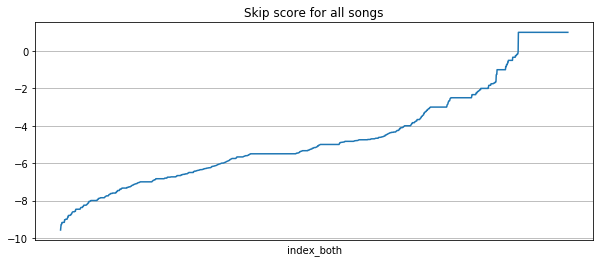

In [58]:
skip_df['skip_score'].sort_values().plot(kind='line',
                                         figsize = (10,4), 
                                         xticks = [], 
                                         grid = True,
                                         title = 'Skip score for all songs')
                                         #xlabel = 'Songs')
                          #ylabel = 'Number of streams'))

### Artists: Stream skips


In [59]:
artist_df['n_skips'] = skip_df.groupby('artistName')['morethan10'].sum() * -1
artist_df['skip_stream'] = artist_df['n_skips'] / artist_df['n_stream']
artist_df['skip_score'] = skip_df.groupby('artistName')['skip_score_w'].mean() + artist_df['weight']


artist_df

,artistName,n_stream,n_songs,weight,nstreamXnsong,song_perstream,perstream_score,n_skips,skip_stream,skip_score
index_artistName,,,,,,,,,,
jeebanoff,jeebanoff,5,2,1.428571,-0.096154,0.476147,-1.095512,4,0.800000,-4.696429
NCT 127,NCT 127,409,33,30.536199,1.119864,17.049726,0.960545,125,0.305623,26.623524
NCT U,NCT U,236,10,9.593496,0.115727,6.934133,0.364432,50,0.211864,7.720394
SEVENTEEN,SEVENTEEN,3282,76,74.279929,22.392283,51.657735,3.000000,487,0.148385,71.973894
Loote,Loote,12,2,1.714286,-0.094892,0.845337,0.005618,7,0.583333,-2.757143
...,...,...,...,...,...,...,...,...,...,...
LIGHTSUM,LIGHTSUM,1,1,0.500000,-0.096966,0.289926,-1.840466,1,1.000000,-1.500000
IVE,IVE,2,1,0.666667,-0.096875,0.666667,-0.333364,0,0.000000,1.666667
2021 Wrapped,2021 Wrapped,4,3,1.714286,-0.095974,0.141452,-2.434419,4,1.000000,-6.785714


# How each song scored

In [60]:
template_compare

,both,bins,n_stream,nstream_score,perstream_score,skip_score
index_both,,,,,,
Son of Beast__TO1,Son of Beast__TO1,6.0,853,24.141413,1.515124,0.819461
Rock with you__SEVENTEEN,Rock with you__SEVENTEEN,6.0,591,13.806967,1.522948,0.796954
0X1=LOVESONG (I Know I Love You) feat. Seori__TOMORROW X TOGETHER,0X1=LOVESONG (I Know I Love You) feat. Seori__...,6.0,499,10.178077,1.418093,0.667335
Down (feat. Grey)__A.C.E,Down (feat. Grey)__A.C.E,6.0,478,9.349744,1.393549,0.640167
SIMPLE__SEVENTEEN,SIMPLE__SEVENTEEN,6.0,368,5.010854,1.342110,0.510870
...,...,...,...,...,...,...
BIM BAM BUM__Rocket Punch,BIM BAM BUM__Rocket Punch,0.0,1,-1.068656,1.596461,1.000000
Ridin'__NCT DREAM,Ridin'__NCT DREAM,0.0,1,-1.068656,1.596461,1.000000
Not Fine__DAY6,Not Fine__DAY6,0.0,1,-1.068656,-2.945766,-11.000000


In [61]:
template_compare['total'] = template_compare.loc[:,'nstream_score':'skip_score'].sum(axis=1)
#total_scores = template_compare.groupby(['both','bins']).sum().agg(sum, axis=1)

template_compare = template_compare.sort_values('total', ascending = False)

template_compare

,both,bins,n_stream,nstream_score,perstream_score,skip_score,total
index_both,,,,,,,
Son of Beast__TO1,Son of Beast__TO1,6.0,853,24.141413,1.515124,0.819461,26.475998
Rock with you__SEVENTEEN,Rock with you__SEVENTEEN,6.0,591,13.806967,1.522948,0.796954,16.126869
0X1=LOVESONG (I Know I Love You) feat. Seori__TOMORROW X TOGETHER,0X1=LOVESONG (I Know I Love You) feat. Seori__...,6.0,499,10.178077,1.418093,0.667335,12.263505
Do Re Mi__SEVENTEEN,Do Re Mi__SEVENTEEN,4.0,75,10.460152,1.093732,0.146667,11.700550
Down (feat. Grey)__A.C.E,Down (feat. Grey)__A.C.E,6.0,478,9.349744,1.393549,0.640167,11.383460
...,...,...,...,...,...,...,...
Voices__Stray Kids,Voices__Stray Kids,1.0,6,-2.037049,-2.860814,-10.166667,-15.064530
All Too Well (10 Minute Version) (Taylor's Version) (From The Vault)__Taylor Swift,All Too Well (10 Minute Version) (Taylor's Ver...,0.0,1,-1.068656,-2.999156,-11.000000,-15.067812
Pyramid__P1Harmony,Pyramid__P1Harmony,0.0,1,-1.068656,-3.000000,-11.000000,-15.068656


In [62]:
### Artists

artist_df['total'] = artist_df['nstreamXnsong'] + artist_df['song_perstream'] + artist_df['skip_score']

artist_df.sort_values('total', ascending = False)

,artistName,n_stream,n_songs,weight,nstreamXnsong,song_perstream,perstream_score,n_skips,skip_stream,skip_score,total
index_artistName,,,,,,,,,,,
SEVENTEEN,SEVENTEEN,3282,76,74.279929,22.392283,51.657735,3.000000,487,0.148385,71.973894,146.023912
BTS,BTS,710,54,50.183246,3.359763,27.283907,1.563647,239,0.336620,46.115212,76.758883
Stray Kids,Stray Kids,1085,39,37.646797,3.718158,24.529034,1.401302,206,0.189862,34.719179,62.966372
ATEEZ,ATEEZ,336,34,30.875676,0.932957,17.052010,0.960680,126,0.375000,26.837137,44.822105
NCT 127,NCT 127,409,33,30.536199,1.119864,17.049726,0.960545,125,0.305623,26.623524,44.793114
...,...,...,...,...,...,...,...,...,...,...,...
Sons of People,Sons of People,1,1,0.500000,-0.096966,0.003291,-2.987113,1,1.000000,-10.500000,-10.593675
Olly Murs,Olly Murs,1,1,0.500000,-0.096966,0.003194,-2.987499,1,1.000000,-10.500000,-10.593771
Tiësto,Tiësto,1,1,0.500000,-0.096966,0.002125,-2.991778,1,1.000000,-10.500000,-10.594841


In [63]:
#template_compare[template_compare['perSong_stream'] == 1]

In [64]:
positive_scores = template_compare.loc[template_compare['total'] > 0, 'total'].sort_values(ascending = False)

#positive_scores.plot(kind = 'barh',
#                    figsize = (5,16))

positive_scores.head(20)

index_both
Son of Beast__TO1                                                    26.475998
Rock with you__SEVENTEEN                                             16.126869
0X1=LOVESONG (I Know I Love You) feat. Seori__TOMORROW X TOGETHER    12.263505
Do Re Mi__SEVENTEEN                                                  11.700550
Down (feat. Grey)__A.C.E                                             11.383460
Easy__Stray Kids                                                     10.894945
pporappippam 보라빛 밤__SUNMI                                            10.660291
Blue Flame__ASTRO                                                    10.514835
Slow Dive__A.C.E                                                     10.093989
Who U Are__KANG DANIEL                                               10.000287
Bambi__BAEKHYUN                                                       9.149726
無限的我 무한적아; LIMITLESS__NCT 127                                         8.926976
DO or NOT__PENTAGON                      

In [65]:
# Print the 5 top songs per bin

binlist = template_compare['bins'].sort_values().unique()
bin_describe = ['Bin 0: 0-5 streams',
                'Bin 1: 6-10 streams',
                'Bin 2: 11-25 streams',
                'Bin 3: 26-50 streams',
                'Bin 4: 51-75 streams',
                'Bin 5: 76-100 streams',
                'Bin 6: More than 100 streams']

N = 15

for (i,bin_describe) in zip(binlist, bin_describe):
    # Extract the top N values in the bin
    bin_df = template_compare.loc[template_compare['bins'] == i, :]
    topN = bin_df.sort_values('total',ascending=False)[['both','total']].head(N)
    print(bin_describe)
    for i in range(0,len(topN)):
        print('{:.3f}: {}'.format(topN.iloc[i,1], topN.iloc[i,0]))
    print('\n')
                

Bin 0: 0-5 streams
4.740: Shhh__SEVENTEEN
4.285: FEEDBACK 너의 대답은__LADIES' CODE
4.235: FUN!__fromis_9
4.235: MY I__SEVENTEEN
4.235: Killing Me__CHUNG HA
4.235: Pirate__EVERGLOW
4.219: Light__UP10TION
3.558: pov__Ariana Grande
3.558: Thunder__VERIVERY
3.558: Lullaby__GOT7
3.558: Superhuman__NCT 127
3.558: LILAC__IU
3.558: CLAP__SEVENTEEN
3.434: If Without You__ATEEZ
3.365: Believe__Paul Blanco


Bin 1: 6-10 streams
4.697: SO BAD__STAYC
3.767: GO GO__CRAVITY
3.652: Twilight__ONEUS
3.627: BAD DREAM__CIX
3.215: Rewind__ONEUS
3.156: Save Me__BTS
3.151: Intentions__Justin Bieber
2.988: BETTER__TWICE
2.830: Promise__ATEEZ
2.638: 34+35__Ariana Grande
2.074: SOMEBODY LIKE__ASTRO
2.027: Can't Live Without You__Toe Fat
2.026: Fanfare__SF9
1.888: My My__SEVENTEEN
1.884: Then, Now and Forever__CNBLUE


Bin 2: 11-25 streams
8.213: That’s It__P1Harmony
7.337: Hot Sauce__TO1
6.515: Queendom__Red Velvet
6.077: Ra Pam Pam__Golden Child
5.886: THRILL RIDE__THE BOYZ
5.825: No More X__TO1
5.608: DOMINO__Str

index_artistName
SEVENTEEN              146.023912
BTS                     76.758883
Stray Kids              62.966372
ATEEZ                   44.822105
NCT 127                 44.793114
Monsta X                42.123328
ASTRO                   39.437814
SF9                     38.012767
THE BOYZ                35.163647
ONEUS                   32.911808
Golden Child            29.425237
TWICE                   29.093657
CRAVITY                 28.326313
WOODZ                   27.797015
VERIVERY                26.979598
TOMORROW X TOGETHER     26.261909
A.C.E                   25.317691
TO1                     21.313659
Ariana Grande           20.388634
BAEKHYUN                19.225904
Name: total, dtype: float64


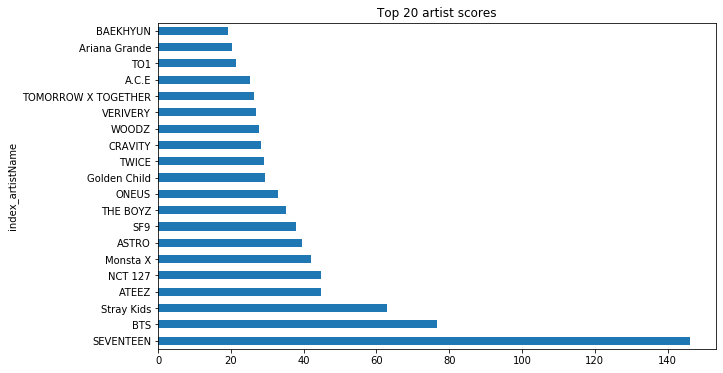

In [66]:
# Print the top 20 artists

artist20 = artist_df.sort_values('total', ascending = False)['total'].head(20)

print(artist20)

artist20.plot(kind = 'barh', 
              figsize = (10,6),
              title = 'Top 20 artist scores')

The original data frame contains 27055 streams
After pruning, the data frame analyzed contains 26822 streams.

In total, I streamed 72662.0 minutes of music (1211.03 hours)
I listened to 548 different artists and 1812 individual tracks
For this analysis, 548 artists and 1879 tracks are considered

The top 10 most streamed tracks are:
853 streams: Son of Beast__TO1
591 streams: Rock with you__SEVENTEEN
499 streams: 0X1=LOVESONG (I Know I Love You) feat. Seori__TOMORROW X TOGETHER
478 streams: Down (feat. Grey)__A.C.E
368 streams: SIMPLE__SEVENTEEN
332 streams: Down (Kor ver.)__A.C.E
292 streams: Tear Drop__SF9
257 streams: Ready to love__SEVENTEEN
252 streams: Cinema__CIX
246 streams: One of Those Nights__KEY


Stream Score: Based on track's number of streams compared to the mean number within a track's bin
Max: 24.141
Min: -9.969
The 10 highest stream number scores are:
24.141: Son of Beast__TO1
13.807: Rock with you__SEVENTEEN
10.460: Blue Flame__ASTRO
10.460: Do Re Mi__SEVENTEEN
10.1

C:\Users\johnt\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 28961 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\johnt\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 38480 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\johnt\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 30340 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\johnt\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 25105 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\johnt\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 47924 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\johnt\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 54620 missing from c

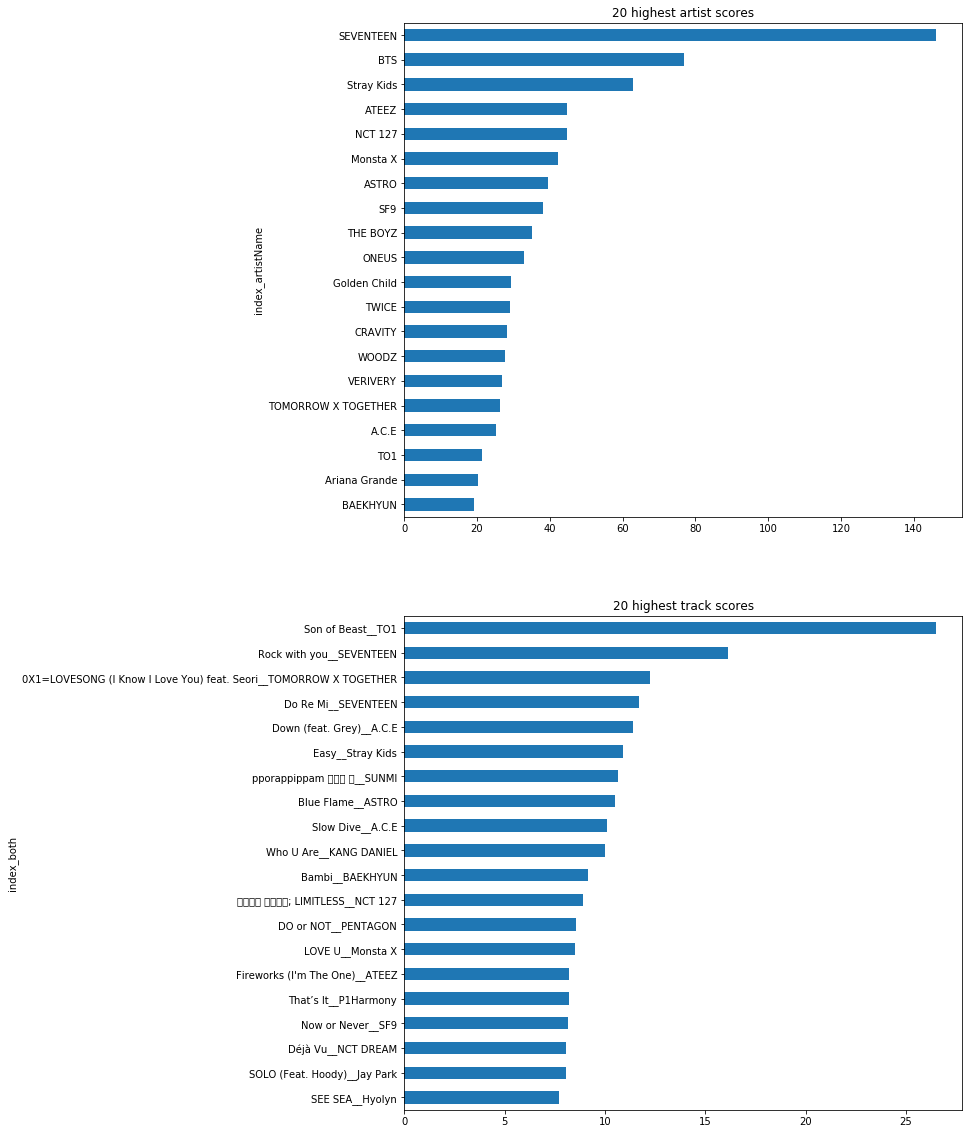

In [77]:
# Outputting all useful information

print('The original data frame contains {} streams'.format(len(output_df)))
print('After pruning, the data frame analyzed contains {} streams.\n'.format(len(template_spot)))
sPlayed = round(output_df['msPlayed'].sum()/(1000*60))
print('In total, I streamed {} minutes of music ({:.2f} hours)'.format(sPlayed, sPlayed/60))
print('I listened to {} different artists and {} individual tracks'.format(output_df['artistName'].nunique(),
                                                                            output_df['trackName'].nunique()))
print('For this analysis, {} artists and {} tracks are considered\n'.format(template_spot['artistName'].nunique(),
                                                                            template_spot['both'].nunique()))

print('The top 10 most streamed tracks are:')
for n,track in zip(track_df.sort_values('n_stream', ascending = False)['n_stream'].head(10),
                   track_df.sort_values('n_stream', ascending = False)['both'].head(10)):
    print('{} streams: {}'.format(n, track))

    
print('\n') ### Spacer
print('Stream Score: Based on track\'s number of streams compared to the mean number within a track\'s bin')
print('Max: {:.3f}\nMin: {:.3f}'.format(track_compare['nstream_score'].max(), track_compare['nstream_score'].min()))
#print('\n') ### Spacer
print('The 10 highest stream number scores are:')
track10 = track_compare.sort_values('nstream_score', ascending = False).head(10)
for name in track10['both'].unique():
    print('{:.3f}: {}'.format(track10.loc[name,'nstream_score'], track10.loc[name,'both']))
    
    
print('\n') ### Spacer
print('Percent Streamed Score: Based on the average % of a track\'s length that is streamed each listen')
print('Max: {:.3f}\nMin: {:.3f}'.format(stream_df['perstream_score'].max(), stream_df['perstream_score'].min()))
#print('\n') ### Spacer
print('{} tracks were 100% streamed each time'.format(len(stream_df[stream_df['per_stream'] == 1])))
print('{} tracks were at least 75% streamed on average'.format(len(stream_df[stream_df['per_stream'] >= .75])))
print('{} tracks were at least 50% streamed on average'.format(len(stream_df[stream_df['per_stream'] >= .5])))
print('{} tracks were only 25% streamed max on average'.format(len(stream_df[stream_df['per_stream'] <= .25])))
print('\n') ### Spacer
highest = stream_df[stream_df['perstream_score'] == stream_df['perstream_score'].max()]
print('{} tracks have the highest percent streamed score'.format(len(highest)))
print('The 10 percent streamed  scores are:')
track10 = stream_df.sort_values('perstream_score', ascending = False).head(10)
for name in track10['both'].unique():
    print('{:.3f}: {}'.format(track10.loc[name,'perstream_score'], track10.loc[name,'both']))


print('\n') ### Spacer
print('Skip Score: Based on the number of times a track was skipped before certain timepoints')
print('Max: {:.3f}\nMin: {:.3f}'.format(skip_df['skip_score'].max(), skip_df['skip_score'].min()))
print('\n') ### Spacer
print('Out of {} streams:'.format(len(template_spot)))
print('{} streams were skipped within 10 seconds'.format(skip_df.loc[:,'skip10'].sum() * -1))
print('{} streams were skipped within 30 seconds'.format(skip_df.loc[:,'skip30'].sum() * -1))
print('{} streams were skipped within 90 seconds'.format(skip_df.loc[:,'skip90'].sum() * -1))
print('{} streams were streamed to within 10 seconds of completion'.format(skip_df.loc[:,'noskip'].sum()))
print('\n') ### Spacer
print('{} tracks have never been streamed to completion'.format(len(skip_df[skip_df['noskip'] == 0])))
print('\n') ### Spacer
highest = skip_df[skip_df['skip_score'] == skip_df['skip_score'].max()]
print('{} tracks have the highest skip score'.format(len(highest)))
print('The 10 highest skip scores are:')
track10 = skip_df.sort_values('skip_score', ascending = False).head(10)
for name in track10['both'].unique():
    print('{:.3f}: {}'.format(track10.loc[name,'skip_score'], track10.loc[name,'both']))
    
    
print('\n') ### Spacer
print('The top 10 most streamed artists are:')
artist10 = artist_df.sort_values('n_stream', ascending = False).head(10)
for name in artist10['artistName'].unique():
    print('{:.0f}: {}'.format(artist10.loc[name,'n_stream'], artist10.loc[name,'artistName']))

print('\n') ### Spacer
all_skip = artist_df[artist_df['skip_stream'] == 1]
print('{} artists had all songs skipped'.format(len(all_skip)))
print('The top 10 most skipped (relative to number of streams) artists are:')
artist10 = artist_df.sort_values('skip_stream', ascending = False).head(10)
for name in artist10['artistName'].unique():
    print('{:.0f} skips / {:.0f} streams: {}'.format(artist10.loc[name,'n_skips'],
                                                     artist10.loc[name, 'n_stream'],
                                                     artist10.loc[name,'artistName']))    

    
print('\n') ### Spacer
print('The top 20 scored songs and artists are:')
artist20 = artist_df.sort_values('total', ascending = False).head(20).reset_index()['artistName']
a_score = artist_df.sort_values('total', ascending = False).head(20).reset_index()['total']
track20 = template_compare.sort_values('total', ascending = False).head(20).reset_index()['both']
s_score = template_compare.sort_values('total', ascending = False).head(20).reset_index()['total']
total20 = pd.DataFrame({'artists':artist20, 
                        'artist_score':a_score,
                        'tracks':track20,
                        'song_score':s_score})

print(total20)
#for (i, (artist, track)) in enumerate(zip(artist20['artistName'].unique(), track20['both'].unique())):
#    print('{}: {}          {}'.format(i+1, artist, track))

# Plot the 20 highest stream scores
artist_bar = artist_df['total'].sort_values(ascending = False).head(20)[::-1]
track_bar = template_compare['total'].sort_values(ascending = False).head(20)[::-1]

fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (10,20),)


artist_bar.plot(kind = 'barh', 
                title = '20 highest artist scores', 
                ax = axes[0])
track_bar.plot(kind = 'barh', 
                title = '20 highest track scores', 
                ax = axes[1])



In [68]:
artist20 = artist_df.sort_values('total', ascending = False).head(20).reset_index()['artistName']
track20 = template_compare.sort_values('total', ascending = False).head(20).reset_index()['both']


tot = pd.DataFrame({'artists':artist20, 'tracks':track20})
tot

,artists,tracks
0,SEVENTEEN,Son of Beast__TO1
1,BTS,Rock with you__SEVENTEEN
2,Stray Kids,0X1=LOVESONG (I Know I Love You) feat. Seori__...
3,ATEEZ,Do Re Mi__SEVENTEEN
4,NCT 127,Down (feat. Grey)__A.C.E
5,Monsta X,Easy__Stray Kids
6,ASTRO,pporappippam 보라빛 밤__SUNMI
7,SF9,Blue Flame__ASTRO
8,THE BOYZ,Slow Dive__A.C.E
9,ONEUS,Who U Are__KANG DANIEL


In [69]:
track_compare

,both,n_stream,bins,nstream_score,mean_tot
index_both,,,,,
Son of Beast__TO1,Son of Beast__TO1,853,6.0,24.141413,877.141413
Rock with you__SEVENTEEN,Rock with you__SEVENTEEN,591,6.0,13.806967,604.806967
0X1=LOVESONG (I Know I Love You) feat. Seori__TOMORROW X TOGETHER,0X1=LOVESONG (I Know I Love You) feat. Seori__...,499,6.0,10.178077,509.178077
Down (feat. Grey)__A.C.E,Down (feat. Grey)__A.C.E,478,6.0,9.349744,487.349744
SIMPLE__SEVENTEEN,SIMPLE__SEVENTEEN,368,6.0,5.010854,373.010854
...,...,...,...,...,...
BIM BAM BUM__Rocket Punch,BIM BAM BUM__Rocket Punch,1,0.0,-1.068656,-0.068656
Ridin'__NCT DREAM,Ridin'__NCT DREAM,1,0.0,-1.068656,-0.068656
Not Fine__DAY6,Not Fine__DAY6,1,0.0,-1.068656,-0.068656
